# 1\. **Introduction**

This is the final project submission by Vijay Yevatkar and Saumya Suvarna for the Fall 2021 semester. 

In this project, we are using data from the murder accountability project. Given certain details of the case, we will try to predict certain characteristics of the offender potentially helping in apprehending the offender. One of our main objectives of this project is to study the propagation of bias through a machine learning pipeline and the ways we can mitigate it at different stages. At the end of this project we want to have made a prediction on a dataset that contains sensitive information, ensure that it is not biased and perform an analysis on the tradeoff of accuracy vs bias in the model.






**Installing required packages**

<img src="https://c.tenor.com/hQ8QszmLrhoAAAAM/everytime-funny.gif" width="400" />



In [1]:
# Basemap toolkit is useed for the geographical plot
!pip install basemap-data
!pip install basemap-data-hires
!pip install basemap

     |████████████████████████████████| 30.5 MB 1.9 MB/s 


     |████████████████████████████████| 91.1 MB 59 kB/s 


     |████████████████████████████████| 881 kB 4.3 MB/s 
     |████████████████████████████████| 6.3 MB 16.6 MB/s 
     |████████████████████████████████| 219 kB 55.5 MB/s 
  Created wheel for pyshp: filename=pyshp-2.1.3-py3-none-any.whl size=37325 sha256=86d98041357228814010afd0bc8c9a5dc911ef1336f37f3459c420f558b35f61
  Stored in directory: /root/.cache/pip/wheels/43/f8/87/53c8cd41545ba20e536ea29a8fcb5431b5f477ca50d5dffbbe
Successfully built pyshp


**Importing required packages**

<img src="https://i.imgflip.com/5x6wgw.jpg" width="400" />




In [2]:
import warnings
warnings.filterwarnings("ignore")

import numpy as np 
import pandas as pd 

# Packages for visualization
import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns
import missingno as mno
import matplotlib.pyplot as plt
import matplotlib.cm
from mpl_toolkits.basemap import Basemap
from matplotlib.patches import Polygon
from matplotlib.collections import PatchCollection
from matplotlib.colors import Normalize

#Packages for imputing data
from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import IterativeImputer
from sklearn.ensemble import ExtraTreesRegressor
from sklearn.preprocessing import OrdinalEncoder

%matplotlib inline

In [3]:
# Setting table to include filter parameters
from google.colab import data_table
data_table.enable_dataframe_formatter()
# #disable setting table to include filter parameters
# from google.colab import data_table
# data_table.disable_dataframe_formatter()
%load_ext google.colab.data_table

**Mounting the drive**

In [4]:
from google.colab import drive
drive.mount('/content/drive')
root_path = '/content/drive/Shareddrives/CIS545_Project/'

Mounted at /content/drive


# 2\. **Data Wrangling**


## 2.1\. **Data Acquisition**

 “More than 256,000 Americans have perished in unsolved homicides committed since 1980 - more than the combined death toll of all U.S. military actions since World War II.”

The dataset we are using is the data collected for the [murder accountability project](http://www.murderdata.org/p/data-docs.html).  With no law enforcement agency in America assigned to monitor failed homicide investigations, this project was set up to track unsolved homicides nationwide. The project provides CSV files summarizing all homicides and homicide clearances reported from year 1965 to 2020. A more detailed description of what information the dataset contains is given [here](https://www.dropbox.com/s/lo6tgo8nnbpqeru/MAPdefinitionsSHR.pdf?dl=1)

In [5]:
#root_path+'input/database.csv'
data = pd.read_csv("https://www.dropbox.com/s/r1f53o4d4xtjudp/SHR76_20.csv?dl=1", dtype='unicode')
data.head(5)

,ID,CNTYFIPS,Ori,State,Agency,Agentype,Source,Solved,Year,StateName,Month,Incident,ActionType,Homicide,Situation,VicAge,VicSex,VicRace,VicEthnic,OffAge,OffSex,OffRace,OffEthnic,Weapon,Relationship,Circumstance,Subcircum,VicCount,OffCount,FileDate,MSA
0,197609001AL00400,"Autauga, AL",AL00400,Alabama,Autauga County,Sheriff,FBI,No,1976,NaN,September,1,Normal update,Murder and non-negligent manslaughter,Single victim/unknown offender(s),30,Male,Black,Unknown or not reported,999,Unknown,Unknown,Unknown or not reported,Other or type unknown,Relationship not determined,Other,NaN,0,0,030180,"Montgomery, AL"
1,197701001AL00400,"Autauga, AL",AL00400,Alabama,Autauga County,Sheriff,FBI,Yes,1977,NaN,January,1,Normal update,Murder and non-negligent manslaughter,Single victim/single offender,65,Female,Black,Unknown or not reported,62,Male,Black,Unknown or not reported,Other or type unknown,Acquaintance,Brawl due to influence of alcohol,NaN,0,0,030180,"Montgomery, AL"
2,197703001AL00400,"Autauga, AL",AL00400,Alabama,Autauga County,Sheriff,FBI,Yes,1977,NaN,March,1,Normal update,Murder and non-negligent manslaughter,Single victim/multiple offenders,48,Male,White,Unknown or not reported,52,Male,White,Unknown or not reported,"Handgun - pistol, revolver, etc",Acquaintance,Other arguments,NaN,0,1,030180,"Montgomery, AL"
3,197703001AL00401,"Autauga, AL",AL00401,Alabama,Prattville,Municipal police,FBI,Yes,1977,NaN,March,1,Normal update,Murder and non-negligent manslaughter,Single victim/single offender,27,Male,Black,Unknown or not reported,22,Female,Black,Unknown or not reported,Shotgun,Husband,Other arguments,NaN,0,0,030180,"Montgomery, AL"
4,197708001AL00400,"Autauga, AL",AL00400,Alabama,Autauga County,Sheriff,FBI,Yes,1977,NaN,August,1,Normal update,Murder and non-negligent manslaughter,Single victim/single offender,17,Female,Black,Unknown or not reported,21,Male,Black,Unknown or not reported,Knife or cutting instrument,Acquaintance,Circumstances undetermined,NaN,0,0,030180,"Montgomery, AL"


**Insights:** From a prelimenary look at the data we can see that there are columns that have a high number of NaN values(eg. StateName) as well as columns that have a unique value that will not be good features for our model(eg. ID).

In [6]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 827219 entries, 0 to 827218
Data columns (total 31 columns):
 #   Column        Non-Null Count   Dtype 
---  ------        --------------   ----- 
 0   ID            827219 non-null  object
 1   CNTYFIPS      827219 non-null  object
 2   Ori           827219 non-null  object
 3   State         827219 non-null  object
 4   Agency        827219 non-null  object
 5   Agentype      827219 non-null  object
 6   Source        827219 non-null  object
 7   Solved        827219 non-null  object
 8   Year          827219 non-null  object
 9   StateName     22468 non-null   object
 10  Month         827219 non-null  object
 11  Incident      827219 non-null  object
 12  ActionType    827219 non-null  object
 13  Homicide      827219 non-null  object
 14  Situation     827219 non-null  object
 15  VicAge        827219 non-null  object
 16  VicSex        827219 non-null  object
 17  VicRace       827219 non-null  object
 18  VicEthnic     827219 non

**Insights:** There are no data types for the columns


<img src="https://media.makeameme.org/created/bad-data-bad.jpg" width="350" />



## 2.2\. **Data Validation and Cleaning**

### 2.2.1\. **Typecasting Columns**

As seen from the previous cell the data requires a lot of cleaning. The first thing we will do is typecast the columns we know are numeric (eg. Age, Year).

In [7]:
# Method to convert a list of columns to numeric
def convertToNumeric(df, col_list):
  for col in col_list:
    df[col] = pd.to_numeric(df[col], errors = "coerce")
  return df

# Convert all the count, age and year columns to numeric
col_list = ['VicAge', 'Year', 'OffAge', 'VicCount', 'OffCount', 'Incident']
data = convertToNumeric(data, col_list)

In [8]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 827219 entries, 0 to 827218
Data columns (total 31 columns):
 #   Column        Non-Null Count   Dtype 
---  ------        --------------   ----- 
 0   ID            827219 non-null  object
 1   CNTYFIPS      827219 non-null  object
 2   Ori           827219 non-null  object
 3   State         827219 non-null  object
 4   Agency        827219 non-null  object
 5   Agentype      827219 non-null  object
 6   Source        827219 non-null  object
 7   Solved        827219 non-null  object
 8   Year          827219 non-null  int64 
 9   StateName     22468 non-null   object
 10  Month         827219 non-null  object
 11  Incident      827219 non-null  int64 
 12  ActionType    827219 non-null  object
 13  Homicide      827219 non-null  object
 14  Situation     827219 non-null  object
 15  VicAge        827219 non-null  int64 
 16  VicSex        827219 non-null  object
 17  VicRace       827219 non-null  object
 18  VicEthnic     827219 non

### **2.2.2\. States Cleaning**
Let us check the number of states. The expected value is 50 since there are 50 states in the United States of America.



In [9]:
all_states = data['State'].unique()
total_state_count = len(all_states)
total_state_count

52


<img src="https://content.twinkl.co.uk/website/uploaded/1-jx8qgzc3woim1lfvbnl5ja-1592312057.jpg" width="350" />


In [10]:
all_states

array(['Alabama', 'Alaska', 'Arizona', 'Arkansas', 'California',
       'Colorado', 'Connecticut', 'Delaware', 'District of Columbia',
       'Florida', 'Georgia', 'Hawaii', 'Idaho', 'Illinois', 'Indiana',
       'Iowa', 'Kansas', 'Kentucky', 'Louisiana', 'Maine', 'Maryland',
       'Massachusetts', 'Michigan', 'Minnesota', 'Mississippi',
       'Missouri', 'Montana', 'Nebraska', 'Nevada', 'New Hampshire',
       'New Jersey', 'New Mexico', 'New York', 'North Carolina',
       'North Dakota', 'Ohio', 'Oklahoma', 'Oregon', 'Pennsylvania',
       'PAPSP8', 'Rhodes Island', 'South Carolina', 'South Dakota',
       'Tennessee', 'Texas', 'Utah', 'Vermont', 'Virginia', 'Washington',
       'West Virginia', 'Wisconsin', 'Wyoming'], dtype=object)

Let us take the expected list of states from [Wikipedia](https://en.wikipedia.org/wiki/List_of_states_and_territories_of_the_United_States#States)

In [11]:
# Let us check what the 2 extra values in our state column are:
expected_states = ["Alabama", "Alaska", "Arizona", "Arkansas", "California", "Colorado", "Connecticut", "Delaware", "Florida", "Georgia", "Hawaii", "Idaho", "Illinois", "Indiana", "Iowa", "Kansas", "Kentucky", "Louisiana", "Maine", "Maryland", "Massachusetts", "Michigan", "Minnesota", "Mississippi", "Missouri", "Montana", "Nebraska", "Nevada", "New Hampshire", "New Jersey", "New Mexico", "New York", "North Carolina", "North Dakota", "Ohio", "Oklahoma", "Oregon", "Pennsylvania", "Rhodes Island", "South Carolina", "South Dakota", "Tennessee", "Texas", "Utah", "Vermont", "Virginia", "Washington", "West Virginia", "Wisconsin", "Wyoming"]
diff_states = list(set(all_states) - set(expected_states))
diff_states

['District of Columbia', 'PAPSP8']

**Insights:** We see that the states that don't belong are "*PAPSP8*" and "*District of Columbia*".

Let us see whether there are significant data points or they are outliers.

In [12]:
print(f"Rows with PAPSP8 as their state: {data[data['State']=='PAPSP8']['Incident'].count()}")
print(f"Rows with District of Columbia as their state: {data[data['State']=='District of Columbia']['Incident'].count()}")

Rows with PAPSP8 as their state: 1
Rows with District of Columbia as their state: 8892


**Insights:** Clearly PAPSP8 is a mistake and we have to drop the only row that contains this entry.

In [13]:
# Drop the PAPSP8 row
data = data[data['State']!='PAPSP8']

**Insights:** 


---
##### The curious case of ***District of Columbia - Pseudo State***
---
Washington D.C. as we know it, was instructed by the US Constitution be a "District (not exceeding ten miles square)” over which Congress would “exercise exclusive legislation." 

This is very important for the Capital because maintaining an isolated district would prevent any state from holding too much power by being home to the national government. 

Going forward we saw that, all of the data has "District of Columbia" as a separate entry in the state column (example Census Data), hence, rather than dropping rows corresponding to Washington DC, we will retain all the data and treat is as a ***51st pseudo state***

### 2.2.2\. **Visulizing the NaNs in the data**


To get a good estimate of how to handle NaN data, we need to first visualize the NaNs in the data


<img src="https://media.makeameme.org/created/something-is-missing-6838a8d575.jpg" width="400" />

In [14]:
# Make a copy as we only wish to show not alter the data
nan_data = data.copy()
pd.set_option('mode.chained_assignment', None)

def modifySubsetAsNan(col, val):
  bools = nan_data[col] == val 
  nan_data[col][bools] = np.nan

# Subset the unknown data and convert it to nan numpy type
vic_age_limit = nan_data["VicAge"] > 99
data["VicAge"][vic_age_limit] = np.nan

perp_age_null = (nan_data['OffAge'] == 0) | (nan_data['OffAge'] == 999)
nan_data["OffAge"][perp_age_null] = np.nan

modifySubsetAsNan("VicSex", "Unknown")
modifySubsetAsNan("VicRace", "Unknown")
modifySubsetAsNan("VicEthnic", "Unknown or not reported")
modifySubsetAsNan("OffSex", "Unknown")
modifySubsetAsNan("OffRace", "Unknown")
modifySubsetAsNan("OffEthnic", "Unknown or not reported")
modifySubsetAsNan("Relationship", "Unknown")
modifySubsetAsNan("Weapon", "Unknown")

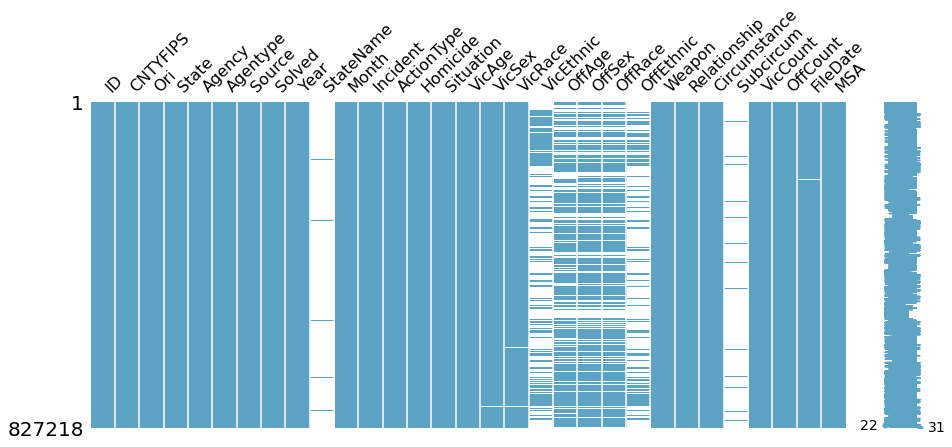

In [15]:
mno.matrix(nan_data, figsize = (15, 6),color=(0.368, 0.647, 0.772))

For the columns where we have NaNs greater than 0, let's look at how much data is missing as a percentage.

In [16]:
nan_data_check = nan_data.isna().sum()
nan_data_pct = nan_data_check/len(nan_data)
nan_data_pct_times = nan_data_pct * 100
nan_data_pct_times[nan_data_pct_times != 0]

StateName    97.284029
VicSex        0.169121
VicRace       1.130899
VicEthnic    58.746062
OffAge       33.280828
OffSex       29.532602
OffRace      30.483258
OffEthnic    71.713502
Subcircum    96.077092
FileDate      0.303427
dtype: float64

**Insights:** 
1. We see that almost all of our data has the basic required data.
2. "StateName" has 97% NaNs. We can drop this column as we already have a "State" column and this one doesn't add any value.
3. "Subcircum" has 96% NaNs which also doesn't add any value.
4. Apart from that, most of the NaNs or Unknowns come from the Unsolved Cases, where every Unsolved case didn't have any information on the Offender - Age, Number of offenders, Ethnicity, etc. This is expected and we will have to take care of these columns during building our model

### 2.2.3\. **Drop Features**

We know that certain features will not help us in the prediction. 

The columns we will drop are:
*   **ID**: It is unique for every row and hence will not be a useful feature.
*   **CNTYFIPS** : It is the state and county of the reporting law enforcement agency. We don't expect this feature to help in our prediction.
*   **Ori**:  Ori is the Originating Agency making the report. Ori also doesn't seem like a feature that will provide much insight.
*   **Agency**: The law enforcement agency
making the report. 
*   **Agentype**: The type of law enforcement agency making
the report (eg 1=Sheriff, 2=County Police). 
*   **Subcircum**: A single-digit alphanumeric variable describing several conditions in which the
victim is reported to have been a criminal offender. Since most of the values are null for these column, it won't provide much insight. 
*   **FileDate**: A six-digit alphanumeric variable describing the date a record was reported, not the
date of the occurrence of the crime. We don't want to add arbitarary dates to our feature set.
*   **MSA**: An eight-digit numeric variable representing the Census Bureau’s Federal Information
Processing Standards (FIPS) code for the Metropolitan Statistical Area from which a record was
reported. This won't give us an information that will help us make a prediction.
*   **StateName**: Alphanumeric variable describing the original FBI naming and abbreviating scheme for the state of the reporting agency. As we saw above, it has a lot of missing values.


<img src="https://c.tenor.com/kxecccHteksAAAAC/not-important-important.gif" width="350" />

In [17]:
data = data.drop(columns=['ID', 'CNTYFIPS', 'Ori', 'Agency', 'Agentype', 'Ori', 'Subcircum', 'FileDate','MSA','StateName'])

### 2.2.3\. **Age Validation**

We will look closely at the OffAge and VicAge columns.

<img src="https://memegenerator.net/img/instances/64404098/99-problems-and-data-wrangling-ranges-from-50-to-80-of-them.jpg" width="250" />

#### 2.2.3.1\. **Trends in Unsolved Cases**
We want to see how are unsolved crimes and the age of the offenders are related.


In [18]:
# Create a Dataframe for the Unsolved Cases
unsolved_df = data[data["Solved"] == "No"]
print(f"The number of unsolved cases are {len(unsolved_df)}")

The number of unsolved cases are 243989


In [19]:
unsolved_offage_invalid999 = unsolved_df[(unsolved_df["OffAge"] == 999)][["OffAge"]]
invalid999 = unsolved_offage_invalid999.value_counts()
print(f"Total cases identified with Age 999 = {invalid999.sum()}")

Total cases identified with Age 999 = 242396


In [20]:
unsolved_offage_invalid0 = unsolved_df[(unsolved_df["OffAge"] == 0)][["OffAge"]]
invalid0 = unsolved_offage_invalid0.value_counts()
print(f"Total cases identified with Age 0 = {invalid0.sum()}")

Total cases identified with Age 0 = 328


Total cases identified with Age = 1265


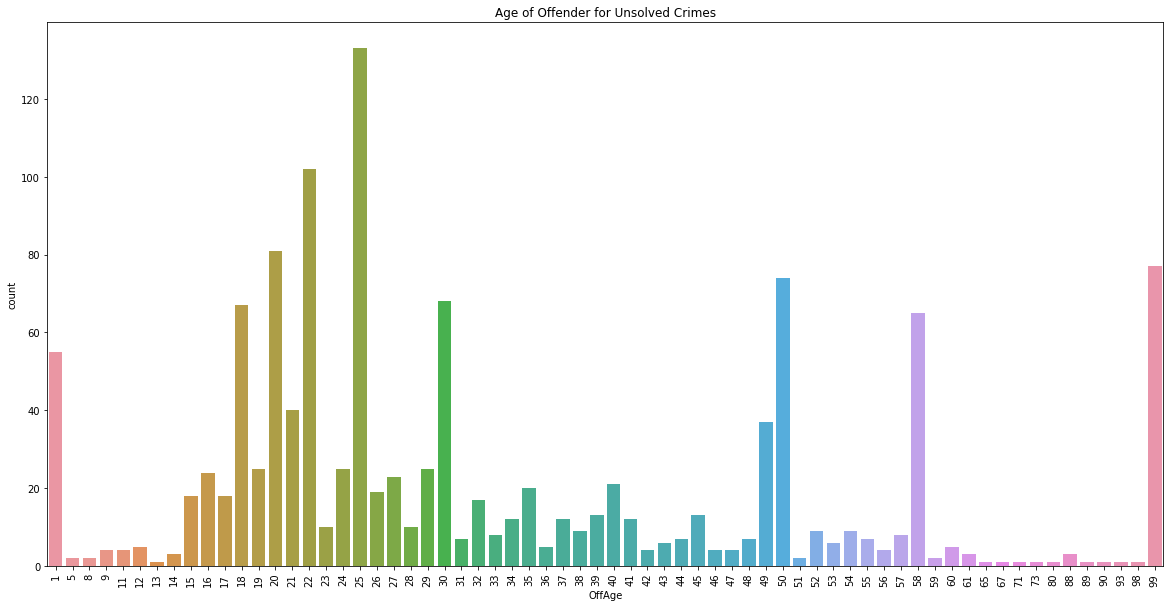

In [21]:
unsolved_offage_valid = unsolved_df[(unsolved_df["OffAge"] > 0) & (unsolved_df["OffAge"] < 150)][["OffAge"]]
fig6, ax6 = plt.subplots(figsize=(20,10))
plot7 = sns.countplot(ax = ax6, x="OffAge", data=unsolved_offage_valid)
plot7.set_xticklabels(plot7.get_xticklabels(), rotation = 90)
plot7.set_title(label='Age of Offender for Unsolved Crimes')
valid_counts = unsolved_offage_valid.value_counts()
print(f"Total cases identified with Age = {valid_counts.sum()}")

**Insights:** 
1. We know that we have a total of 243989 unsolved cases.
2. When we plot the valid range of ages, we see that out of these 243k cases, only 1265 cases have the ages of the offenders
3. After looking closely, almost all of the offenders are marked with age 999 and a few of them are marked as 0.

#### 2.2.3.1\. Offender Ages Validation and Cleaning

In [22]:
# replace blank strings with zeros
data['OffAge'] = data['OffAge'].replace(" ", 0)

# convert to integers
data['OffAge'] = data['OffAge'].astype(str).astype(float).astype(int)

# See if the spaces are gone and that if strings became integers
data['OffAge'].unique()

array([999,  62,  52,  22,  21,  80,  54,  26,  24,  68,  28,  20,  44,
        17,  29,  55,  23,  58,  45,  35,  36,  50,  31,  34,  32,  39,
        47,  33,  73,  18,  40,  53,  59,  51,  19,  27,  30,  38,  25,
        61,  70,  16,  42,  41,  48,  46,  37,  60,  71,  66,  43,  67,
        64,  57,  89,  14,  74,  75,  15,  78,  56,  81,  69,  63,  13,
        49,  83,  82,  79,  76,  77,  65,  72,  84,  12,  86,  93,  11,
        91,  10,  85,  90,   9,  92,  99,   1,   8,  87,   7,   2,   5,
         6,   4,  88,  94,   3,  96,  95,  97,   0,  98])

**Insights:** 
The data for the perpetrator age greater than 150 years and less than 6 years is spurious data (the youngest homicide perpetrator was 6 years old). So we replace the data by NaN.

In [23]:
# subset the age 998
off_age_limit = data["OffAge"] > 150

# replace them with nan values for that column
data["OffAge"][off_age_limit] = np.nan
# replacing perpetrators under the age 6 with NAN

# search for ages below 6
# This returns True/False
under_6 = data["OffAge"] < 6

# replace them with nan values for that column
data["OffAge"][under_6] = np.nan
data['OffAge'].unique()

array([nan, 62., 52., 22., 21., 80., 54., 26., 24., 68., 28., 20., 44.,
       17., 29., 55., 23., 58., 45., 35., 36., 50., 31., 34., 32., 39.,
       47., 33., 73., 18., 40., 53., 59., 51., 19., 27., 30., 38., 25.,
       61., 70., 16., 42., 41., 48., 46., 37., 60., 71., 66., 43., 67.,
       64., 57., 89., 14., 74., 75., 15., 78., 56., 81., 69., 63., 13.,
       49., 83., 82., 79., 76., 77., 65., 72., 84., 12., 86., 93., 11.,
       91., 10., 85., 90.,  9., 92., 99.,  8., 87.,  7.,  6., 88., 94.,
       96., 95., 97., 98.])

#### 2.2.3.2\. Victim Ages Validation and Cleaning


Replace VicAge with NaN if victim age is greater than 150 years.

In [24]:
# subset the age 998
vic_age_limit = data["VicAge"] > 150

# replace them with nan values for that column
data["VicAge"][vic_age_limit] = np.nan

In [25]:
print(data['VicAge'].unique())

[30. 65. 48. 27. 17. 62. 54. nan 51. 24. 44. 67. 38. 28. 16. 56. 33. 70.
 25. 22. 43. 55. 34. 36. 29. 53. 31. 41. 46. 23. 19. 80. 83. 50. 90. 69.
 39. 11. 20. 47. 32. 21. 18. 64. 72. 45. 59. 40. 63. 52. 66. 26.  1.  2.
 49. 35. 42. 76. 60. 73. 15.  3. 75. 57. 77. 12. 10.  5. 68. 79. 61. 78.
 82. 71. 37. 74. 58. 96. 81. 14. 88. 84. 13.  0. 85. 89.  4. 87.  7.  8.
 86.  6.  9. 91. 92. 94. 99. 95. 98. 93. 97.]


### **2.2.4\. Data Distribution**

Lets see proportion of solved vs unsolved murders to see if the data is disproportional and there is a stark class imbalance which would require us to undersample or oversample the data.



Solved Cases = 583229 and Unsolved Cases = 243989



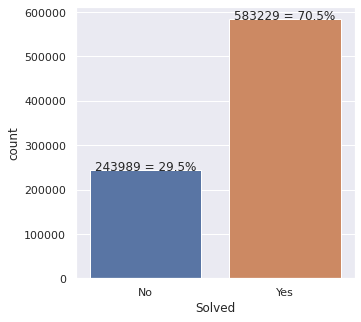

In [26]:
# Let us see the data distribution of Solved vs. Unsolved cases to see if we have any class imbalance
cases_counts = data["Solved"].value_counts(dropna=False)
sns.set_theme(style="darkgrid")
fig1, ax1 = plt.subplots(figsize=(5,5))
plot = sns.countplot(ax = ax1, x="Solved", data=data)
i = 1
l = cases_counts.sum()
for p in plot.patches:
    height = p.get_height()
    percentage = round(cases_counts[i%2]*100 / l, 2)
    plot.text(p.get_x()+p.get_width()/2., height + 0.1,
        f"{cases_counts[i%2]} = {percentage}%", ha="center")
    i += 1
solved_cases, unsolved_cases = cases_counts["Yes"].sum(), cases_counts["No"].sum()
print(f"Solved Cases = {solved_cases} and Unsolved Cases = {unsolved_cases}\n")

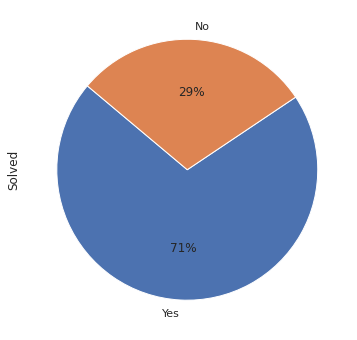

In [27]:
data['Solved'].value_counts().plot.pie(autopct='%1.0f%%', figsize=(6,6),  colors = sns.color_palette()[:2], startangle=140)

**Insights:**  Our data is distributed with a 30-70 split. Based on the figure, the data is not very dispropotional and we do not need under or over sampling.

In [28]:
# Function to show counts on top of each countplot
def showCounts(plot, series):
  i = 0
  for p in plot.patches:
    height = p.get_height()
    plot.text(p.get_x()+p.get_width()/2., height + 0.1,
        series[i], ha="center")
    i += 1 

# 3.Exploratory Data Analysis (EDA)

In this section we want to get a better understanding of the data.

### 3.1\. PairPlot
Plotting a pairwise plot for all features to view large amount of information all at once and to check if we see any trends between the numerical data.

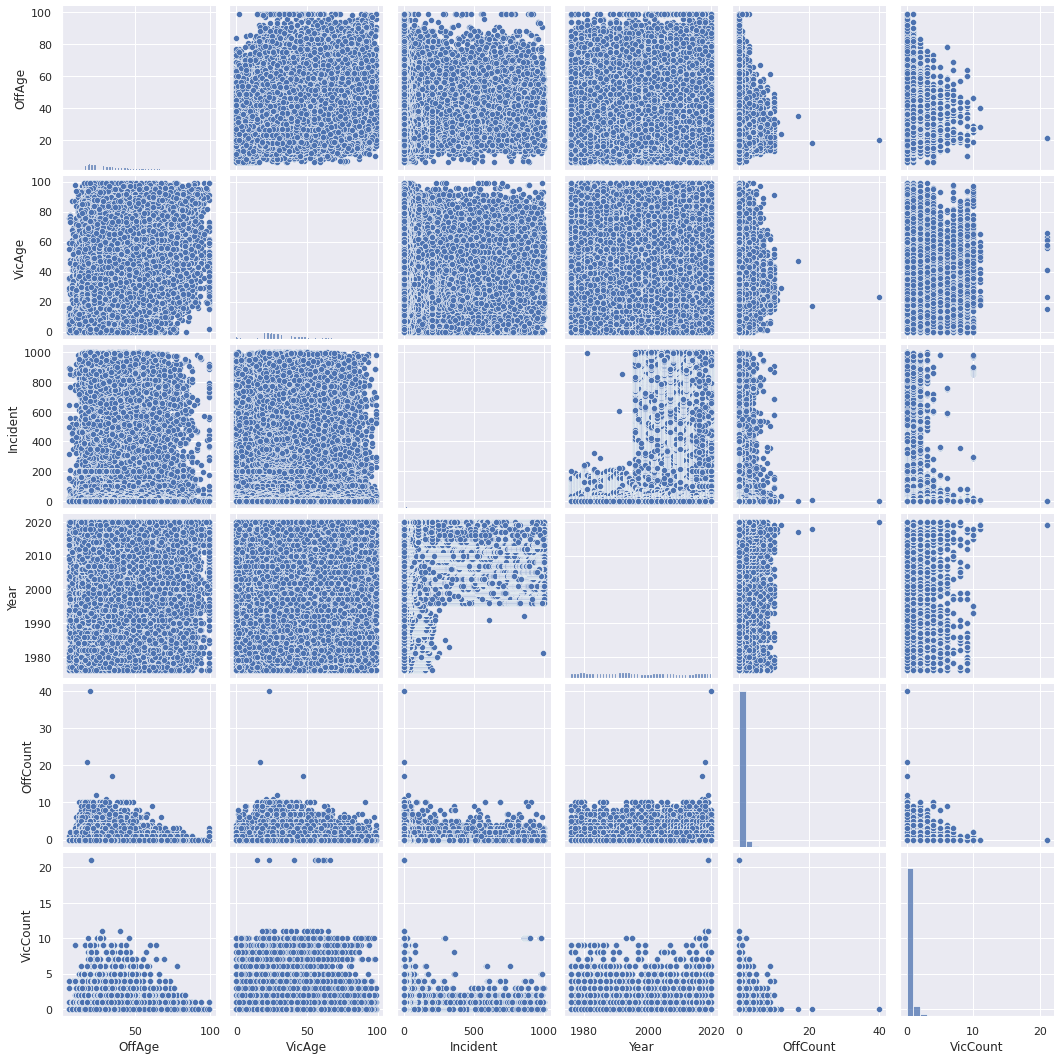

In [29]:
sns.set()
cols = ['OffAge', 'VicAge', 'Incident', 'Year','OffCount', 'VicCount']

sns.pairplot(data[cols], height = 2.5,palette= sns.color_palette('pastel'))
plt.show()

**Insights:** Unfortunately the pairplot did not give us any particular insights.

### 3.2\. Correlation Matrix
We look at whether the numeric data is correlated or not.

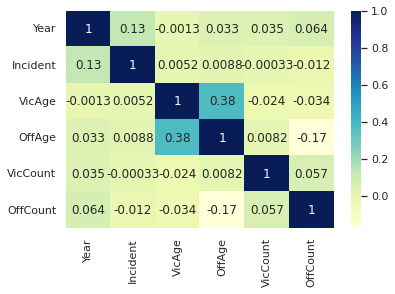

In [30]:
correlation = data.corr()
# correlation
sns.heatmap(correlation,cmap="YlGnBu",annot=True)

**Insights:** We see that the numeric features are not strongly correlated. The most correlated features (38%) between victim age and offender age.

### 3.3\. Age Data Analysis

#### 3.3.1\. Trends in Age Distribution

Let us compare the plots of the ages of the victims and the offenders.

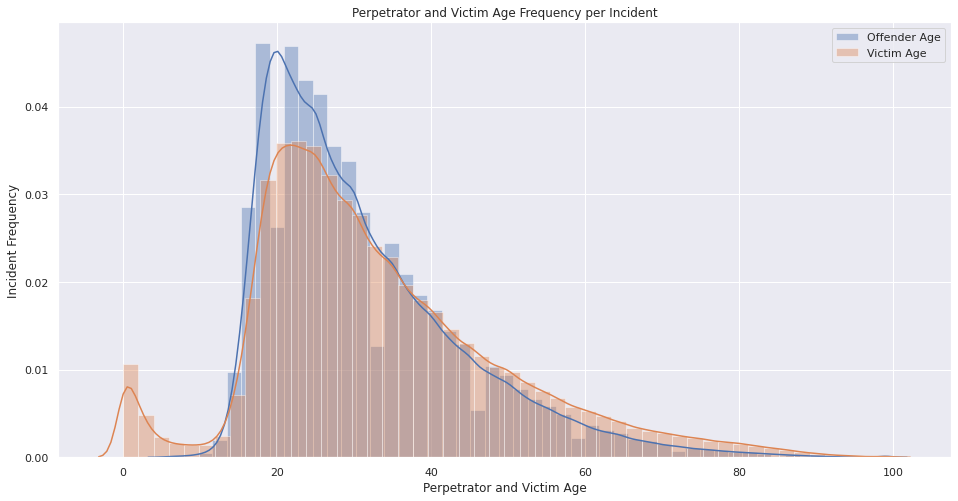

In [31]:
plt.subplots(figsize=(16, 8))
sns.distplot( data["OffAge"] , label="Offender Age") 
sns.distplot( data["VicAge"] , label="Victim Age") 
plt.title('Perpetrator and Victim Age Frequency per Incident')
plt.xlabel('Perpetrator and Victim Age')
plt.ylabel('Incident Frequency')
plt.legend()

**Insights:** Most of the offenders are 18 - 35 years old. The data is skewed to the left. Based on [this report](https://www.cdc.gov/mmwr/volumes/68/wr/mm6803a1.htm) a few reasons for this might be:
*   The accesibility and availability of information on weapons as well as personal information on the internet.
*   Rising divorce rates.
*   Domestic violence.

We see a small spike in the homicides of infants. Based on [this report](https://www.childtrends.org/wp-content/uploads/2016/03/indicator_1457608611.364.html) some of the reasons might be:
*   Circumstances surrounding the birth.
*   Maternal risk factors including poverty and unplanned pregnancy.
*   A number of homicides among very young infants go unreported.

#### 3.3.2\. Age Statistics 

Let us see what the age at which the probability of being a victim of homicide is the highest and the average age of the offender.

In [32]:
print(f"The average age of the victims is: {data['VicAge'].median()}")
print(f"The most common homicide victim age is: {data['VicAge'].mode()[0]}")
print(f"The average age of the offenders is: {data['OffAge'].median()}")
print(f"The most common offender age is: {data['OffAge'].mode()[0]}") 

The average age of the victims is: 30.0
The most common homicide victim age is: 22.0
The average age of the offenders is: 28.0
The most common offender age is: 20.0


**Insights:** Victims are usually older than offenders. The **most frequent** victim age is 22 compared 20 for perpetrators, and 75% of the data is for the ages 46 and younger.

### 3.4\. Weapon Data Analysis

Let take a look at the different weapons used and their frequency.

In [33]:
print('The list of weapons used in the homicides:')
print(data['Weapon'].value_counts())
print('The most popular weapon is the',data['Weapon'].value_counts().index[0].lower())

The list of weapons used in the homicides:
Handgun - pistol, revolver, etc         404196
Knife or cutting instrument             119912
Firearm, type not stated                 74381
Personal weapons, includes beating       47142
Other or type unknown                    43412
Shotgun                                  39330
Blunt object - hammer, club, etc         36116
Rifle                                    30701
Strangulation - hanging                  10100
Fire                                      7890
Asphyxiation - includes death by gas      5041
Other gun                                 3218
Narcotics or drugs, sleeping pills        2791
Drowning                                  1511
Explosives                                 630
Poison - does not include gas              586
Pushed or thrown out window                261
Name: Weapon, dtype: int64
The most popular weapon is the handgun - pistol, revolver, etc


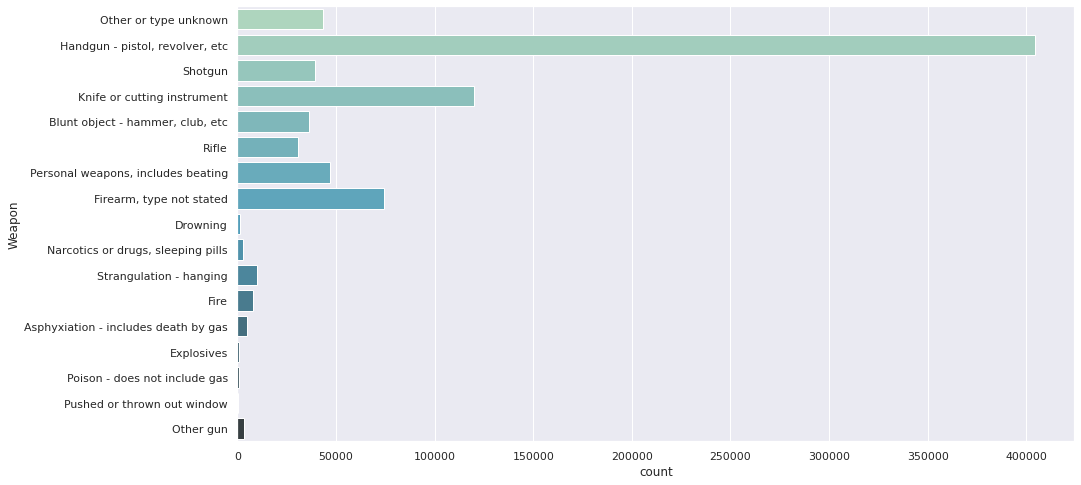

In [34]:
sns.set(style="darkgrid")
sns.set(rc = {'figure.figsize':(15,8)})
sns.countplot(y="Weapon",data=data, palette="GnBu_d")

In [35]:
data.Weapon.unique()

array(['Other or type unknown', 'Handgun - pistol, revolver, etc',
       'Shotgun', 'Knife or cutting instrument',
       'Blunt object - hammer, club, etc', 'Rifle',
       'Personal weapons, includes beating', 'Firearm, type not stated',
       'Drowning', 'Narcotics or drugs, sleeping pills',
       'Strangulation - hanging', 'Fire',
       'Asphyxiation - includes death by gas', 'Explosives',
       'Poison - does not include gas', 'Pushed or thrown out window',
       'Other gun'], dtype=object)

**Insights:** Some of these weapons fall into the same firearm category: 'Handgun - pistol, revolver, etc', handguns, 'Shotgun', 'Rifle', 'Firearm, 'Other gun'. Hence we will combine them into one 'firearm' category.

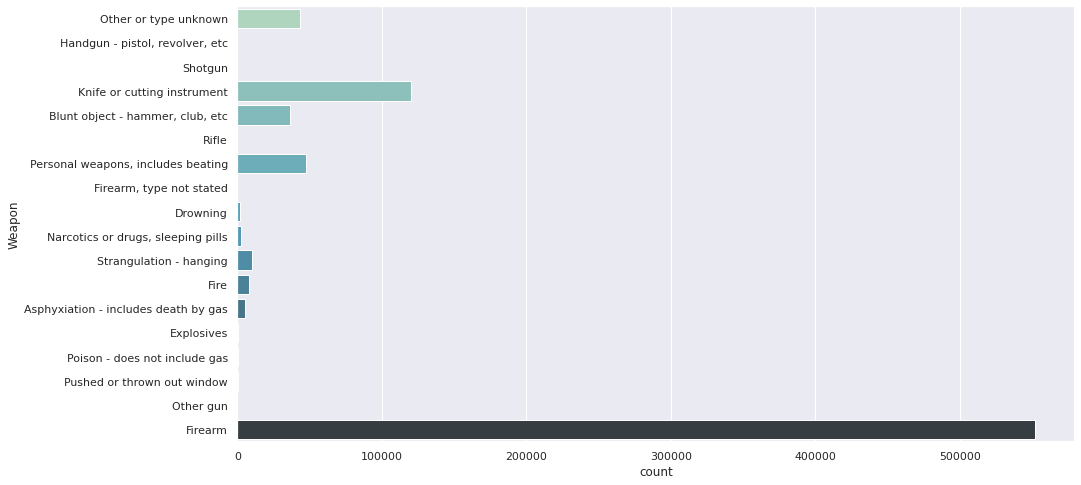

In [36]:
categories = np.array(['Other or type unknown',
 'Handgun - pistol, revolver, etc',
 'Shotgun',
 'Knife or cutting instrument',
 'Blunt object - hammer, club, etc',
 'Rifle',
 'Personal weapons, includes beating',
 'Firearm, type not stated',
 'Drowning',
 'Narcotics or drugs, sleeping pills',
 'Strangulation - hanging',
 'Fire',
 'Asphyxiation - includes death by gas',
 'Explosives',
 'Poison - does not include gas',
 'Pushed or thrown out window',
 'Other gun',
 'Firearm'])
murder_guns_combined = data
murder_guns_combined['Weapon'] = pd.Categorical(murder_guns_combined['Weapon'], categories=categories, ordered=True)
murder_guns_combined.loc[murder_guns_combined['Weapon']=='Handgun - pistol, revolver, etc', 'Weapon'] = 'Firearm'
murder_guns_combined.loc[murder_guns_combined['Weapon']=='Rifle', 'Weapon'] = 'Firearm'
murder_guns_combined.loc[murder_guns_combined['Weapon']=='Shotgun', 'Weapon'] = 'Firearm'
murder_guns_combined.loc[murder_guns_combined['Weapon']=='Firearm, type not stated', 'Weapon'] = 'Firearm'
murder_guns_combined.loc[murder_guns_combined['Weapon']=='Other gun', 'Weapon'] = 'Firearm'

sns.countplot(y="Weapon",data=murder_guns_combined, palette="GnBu_d");

**Insights:** From the graph we see that the most frequently used weapon for commiting homicides is **Firearms**.

### 3.5\. Relationship Data Analysis

Now we look at the relationship with the victim age

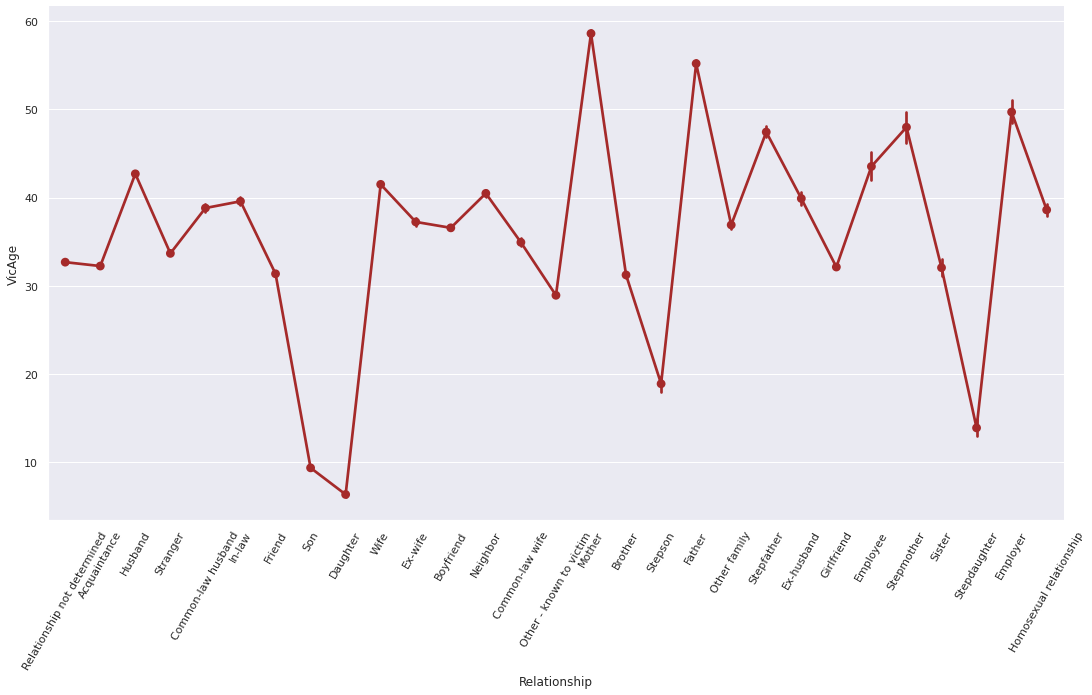

In [37]:
g = sns.catplot(x='Relationship', y='VicAge', data=data, kind="point", color='brown', height=8, aspect=2)
g.set_xticklabels(rotation=60)

In [38]:
plt.figure(figsize=(12,15))
known = data[data['OffSex'] != 'Unknown']
known = known[known['Relationship'] != 'Relationship not determined']
known = known[known['Relationship'] != 'Boyfriend']
known = known[known['Relationship'] != 'Girlfriend']

<Figure size 864x1080 with 0 Axes>

Let us see the relationship distribution with respect to different offender sex ie. is there a relationship between offender sex and the relationship of the victim

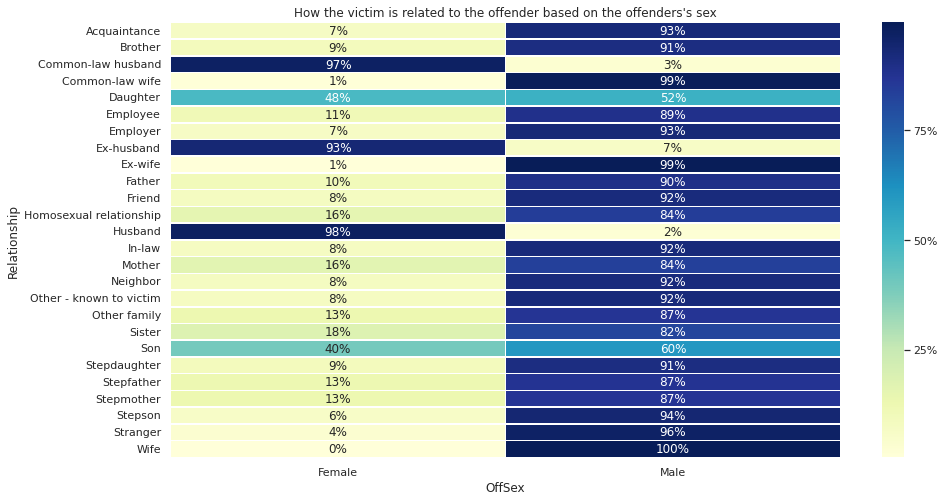

In [39]:
ax = sns.heatmap(pd.crosstab(known['Relationship'], known['OffSex']).apply(lambda r: r/r.sum(), axis=1), annot=True, fmt=".0%", linewidths=.5,cmap='YlGnBu')
ax.set_title("How the victim is related to the offender based on the offenders's sex")
cbar = ax.collections[0].colorbar
cbar.set_ticks([0, .25, .50, .75, 1])
cbar.set_ticklabels(['0%', '25%', '50%',  '75%', '100%'])


**Insights:** From the graph we see that for female offenders, the more common victim is husbands.

### 3.6\. Year Data Analysis

---
##### 3.6.1\. Homicide Trends
----



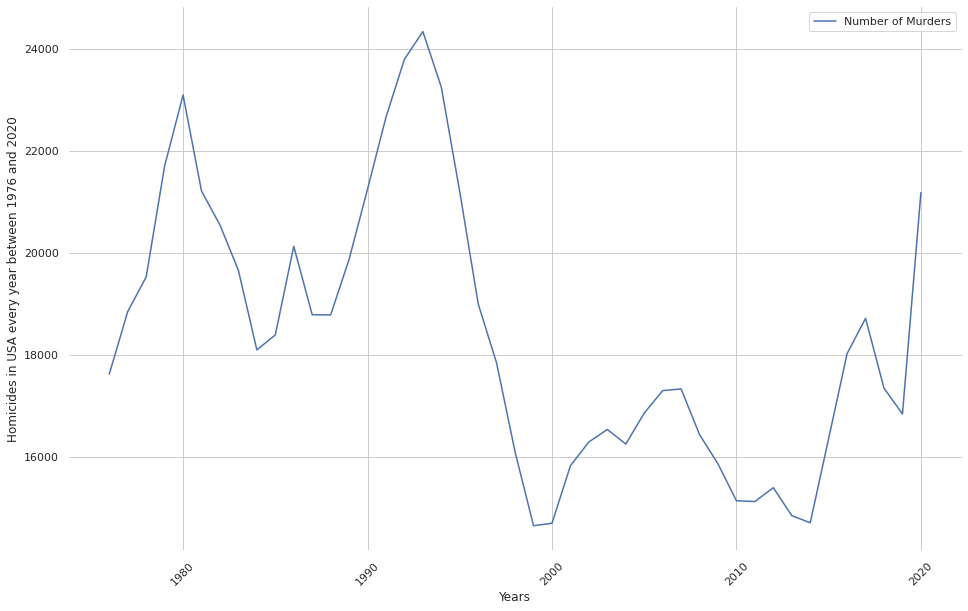

In [40]:
homicides = data.groupby('Year').agg(count = ('Incident','count')).reset_index()
sns.set(style="whitegrid")
f, ax = plt.subplots(figsize=(16, 10))

sns.lineplot(y='count', x="Year", data=homicides,label="Number of Murders")

ax.legend(ncol=2, loc="upper right", frameon=True)
ax.set( xlabel="Years", ylabel="Homicides in USA every year between 1976 and 2020")
plt.xticks(rotation=45)
sns.despine(left=True, bottom=True)

**Insights:** The overall trend of murders shows decreased. However we can look at some areas where the crimes risen and look at the reason for this trend. In 1985 the crack cocaine market grew. According to [this report](https://pubs.aeaweb.org/doi/pdf/10.1257/089533004773563485) some of the interesting reasons are:
1.   About 25% of homicides are crack related. Interestingly enough the homicides are involved in crack distribution rather than the psychopharmological effects of crack.
2.   Crime peaked during financial crisis, according to the [UNODC report Monitoring the Impact of Economic Crisis on Crime](https://www.unodc.org/unodc/en/frontpage/2012/February/economic-crises-can-trigger-rise-in-crime.html). 
3. The increased number of police officers was one of the reasons homicide decreased sharply fell in the 1990's. 
    *   The police officers increased by 14 percent (50,000-60,000) in the 1990s.
    *   Crime reduced by 5-6 percent between 1991 and 2001.
    *   1/5th to 1/10th of the overall decline in crime can be explained by the increase in police.
4. The rising prison population
    *   2 million individuals were incarcerated by 2000 which was four times the number locked up in 1972.
    *   Half of the prison population growth tok place in 1990s.
    *   The sharp rise of prisoners was due to drug-related offenses.
        - increase revocation of parole 
        - longer sentences
        - increased punishment
            - the threat of punishment became a large deterent of crime causing the reduction in homicide of about 12 percent.
5. The legalization of abortion. The negative impact of adverse home environments on eventual criminality, has been stated [here](https://www.jstor.org/stable/2657324).
6. Political and Social Unrest during 2020 from this [Source](https://www.pewresearch.org/fact-tank/2021/10/27/what-we-know-about-the-increase-in-u-s-murders-in-2020)
    - The COVID-19 pandemic saw a surge of violence as people struggled to get acess to essential items. 
    - The year 2020 saw a lot of political unrest with the election of the new president. 
    - There was also a lot of violence related to the clashes between the regulatory force and protestors for various social revolutions like the BLM movement.

Let us highlight these years in the graph to draw attention to these specific events and see if our assumption is correct.

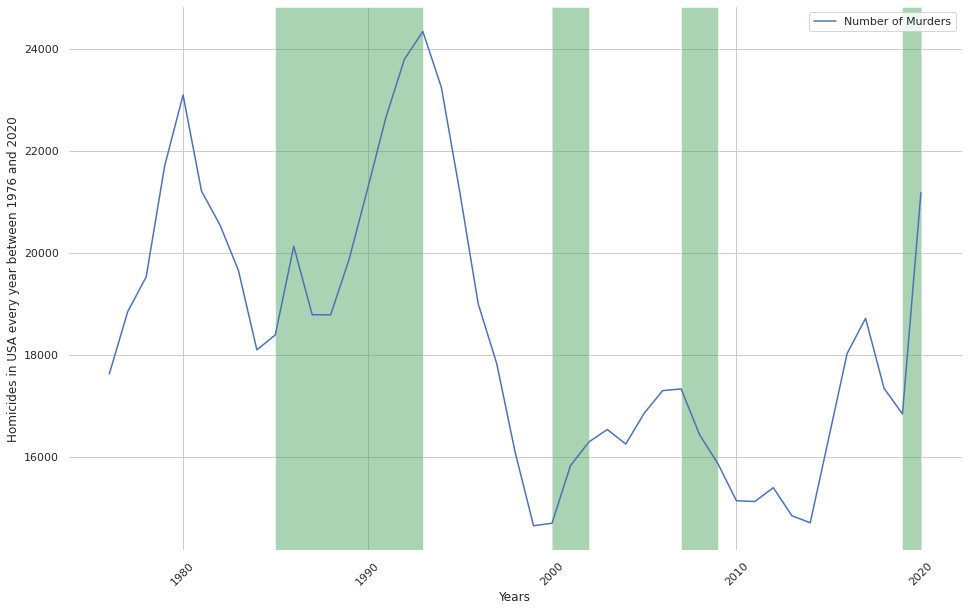

In [41]:
country_incidences = data.groupby('Year')['Incident'].agg('count')
country_incidences = country_incidences.reset_index()

fig, ax = plt.subplots(figsize=(16, 10))
sns.lineplot(data=country_incidences, x='Year',y='Incident',label="Number of Murders")
ax.legend(ncol=2, loc="upper right", frameon=True)
ax.set( xlabel="Years", ylabel="Homicides in USA every year between 1976 and 2020")
plt.xticks(rotation=45)
sns.despine(left=True, bottom=True)

plt.axvspan(2000,2002,facecolor='g', alpha=0.5)
plt.axvspan(2007,2009,facecolor='g', alpha=0.5)
plt.axvspan(1985,1993,facecolor='g', alpha=0.5)
plt.axvspan(2019,2020,facecolor='g', alpha=0.5)

**Insights:** We see that most of our assumptions are correct.

---
##### 3.6.2\. Change in Number of Homicides 
----
We want to calculate the percentage change in incidences. 


Text(0.5, 1.0, 'Percentage Change of USA Homicides during 1965 - 2020')

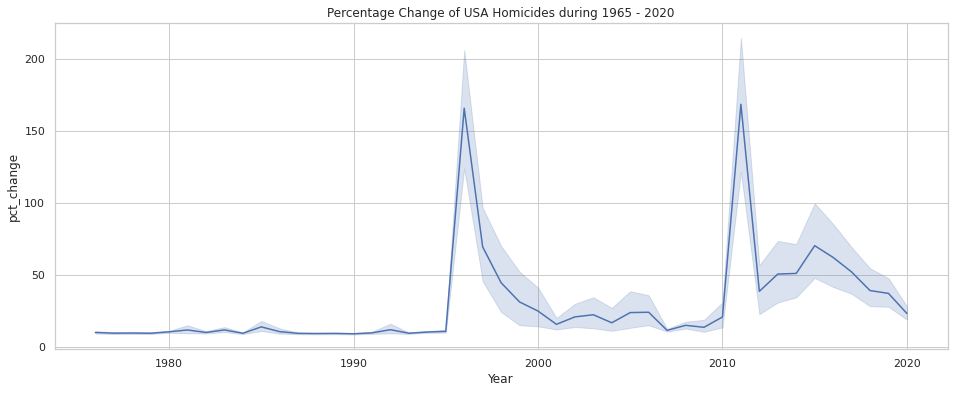

In [42]:
pct_change = data[['Year','Incident']]
pct_change["pct_change"] = pct_change["Incident"].pct_change()*100
plt.figure(figsize=(16, 6))
sns.lineplot(x='Year',y='pct_change',data=pct_change).set_title("Percentage Change of USA Homicides during 1965 - 2020")

In [43]:
year_min = data['Year'].value_counts().index[34]
total_year_min = data['Year'].value_counts().min()
print(f"The year with the least homicides was {year_min} with a total of {total_year_min} murders.")
year_max = data['Year'].value_counts().index[0]
total_year_max = data['Year'].value_counts().max()
print(f"The year with the most homicides was {year_max} with a total of {total_year_max} murders.")

The year with the least homicides was 2004 with a total of 14644 murders.
The year with the most homicides was 1993 with a total of 24337 murders.


**Insights:** We see the biggest percentage increase in the begining of the crack epidemic and the biggest decrease in the end. There is also an increase in the begining of the dot com crisis at the end of the 1990's.


### 3.7\. Month Data Analysis

Let us see if there is any trend in the distribution of crimes based on the months when they occured.

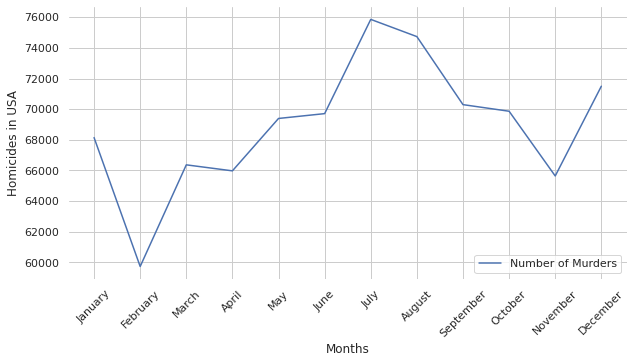

In [44]:
homicides = data.groupby('Month').agg(count = ('Incident','count')).reset_index()
homicides = homicides.sort_values(by = 'Month')
homicides["Month"] = pd.to_datetime(homicides.Month, format='%B', errors='coerce').dt.month
homicides = homicides.sort_values(by="Month")
homicides['Month'] = pd.to_datetime(homicides['Month'], format='%m').dt.month_name()
sns.set(style="whitegrid")

f, ax = plt.subplots(figsize=(10, 5))

sns.lineplot(y='count', x="Month", data=homicides, label="Number of Murders",palette= sns.color_palette('pastel')) #palette= sns.color_palette('pastel'))#colorblind

ax.legend(ncol=2, loc="lower right", frameon=True)
ax.set( xlabel="Months", ylabel="Homicides in USA")
plt.xticks(rotation=45)
sns.despine(left=True, bottom=True)


**Insights:** Based on the histogram we can see that the most homisides take place in the summer while it is warmer. [Source](https://www.nytimes.com/2009/06/19/nyregion/19murder.html?mtrref=www.google.com&gwh=B94888DCB6D671995B1212D1ADB75007&gwt=pay&assetType=REGIWALL). The reason for the increase in December - January is probably because of the holiday season.

### 3.8\. State Data Analysis

Let us try to draw insights from the distribution of incidences across different states.

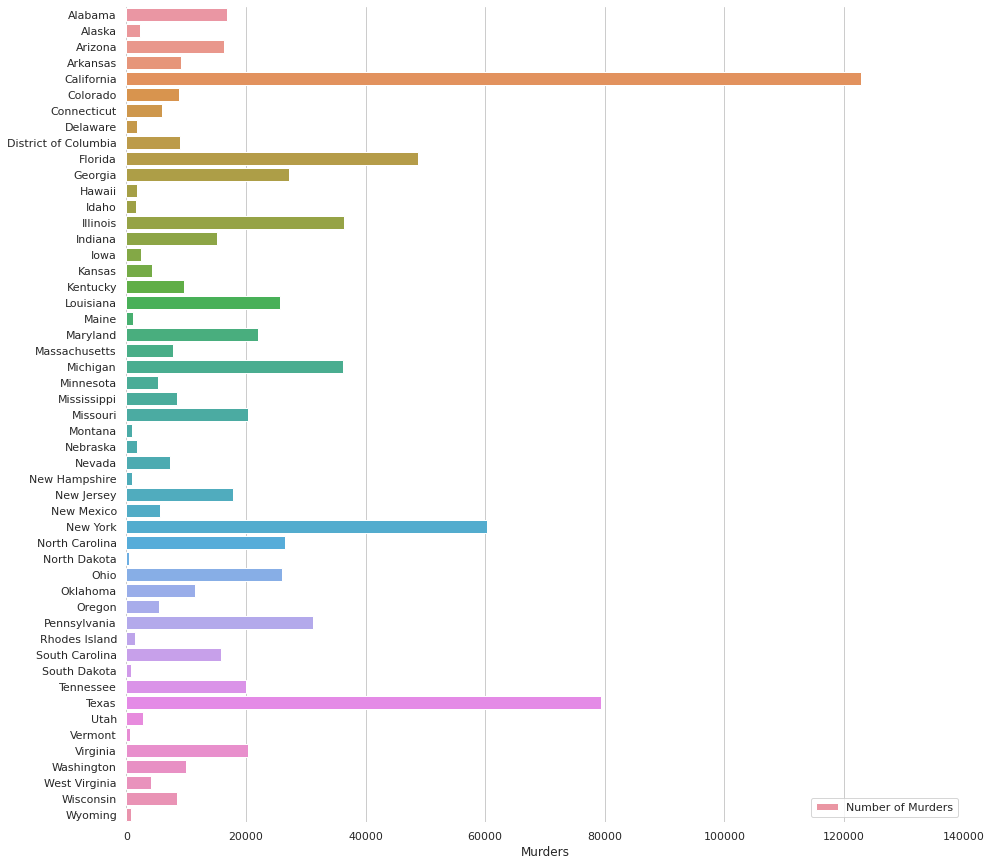

In [45]:
state = data.groupby('State').agg(count = ('Incident','count')).reset_index()
sns.set(style="whitegrid")
f, ax = plt.subplots(figsize=(15, 15))
sns.barplot(x='count', y="State", data=state, label="Number of Murders")
ax.legend(ncol=2, loc="lower right", frameon=True)
ax.set(xlim=(0, 140000), ylabel="", xlabel="Murders")
sns.despine(left=True, bottom=True)


In [46]:
state_max = data['State'].value_counts().index[0]
total_state_max = data['State'].value_counts().max()
state_min = data['State'].value_counts().index[50]
total_state_min = data['State'].value_counts().min()

print('The state with the highest number of murders was', state_max,'with a total of', total_state_max, 'murders')
print('The state with the lowest number of murders was', state_min,'with a total of', total_state_min, 'murders')
print('The top 3 most dangerous states in terms of murders are:\n', data['State'].value_counts().nlargest(3))

The state with the highest number of murders was California with a total of 122841 murders
The state with the lowest number of murders was North Dakota with a total of 494 murders
The top 3 most dangerous states in terms of murders are:
 California    122841
Texas          79366
New York       60336
Name: State, dtype: int64


<img src="https://miro.medium.com/max/1313/1*SFf3VczKcQODbUZ3Ik2H6g.gif" width="350" />

**Insights:** The figure above might be an example of **framing bias** in visualization. This plot could be visually biased because it makes a viewer believe that states like California and Texas have a very high crime rate while it might be that the number of crimes is due to the large population. 

#### 3.8.1\. Census Data Acquisition

Let us verify if the states in the previous have a high crime rate by getting an ratio of number of homicides by the total population of the state. We get the population [data](https://www2.census.gov/programs-surveys/popest/datasets/2010-2020/state/totals/) by US census. 

In [47]:
census_data =  pd.read_csv("https://www2.census.gov/programs-surveys/popest/datasets/2010-2020/state/totals/nst-est2020-alldata.csv")
census_data.head(10)

,SUMLEV,REGION,DIVISION,STATE,NAME,CENSUS2010POP,ESTIMATESBASE2010,POPESTIMATE2010,POPESTIMATE2011,POPESTIMATE2012,POPESTIMATE2013,POPESTIMATE2014,POPESTIMATE2015,POPESTIMATE2016,POPESTIMATE2017,POPESTIMATE2018,POPESTIMATE2019,POPESTIMATE2020,NPOPCHG_2010,NPOPCHG_2011,NPOPCHG_2012,NPOPCHG_2013,NPOPCHG_2014,NPOPCHG_2015,NPOPCHG_2016,NPOPCHG_2017,NPOPCHG_2018,NPOPCHG_2019,NPOPCHG_2020,BIRTHS2010,BIRTHS2011,BIRTHS2012,BIRTHS2013,BIRTHS2014,BIRTHS2015,BIRTHS2016,BIRTHS2017,BIRTHS2018,BIRTHS2019,BIRTHS2020,...,RNATURALINC2011,RNATURALINC2012,RNATURALINC2013,RNATURALINC2014,RNATURALINC2015,RNATURALINC2016,RNATURALINC2017,RNATURALINC2018,RNATURALINC2019,RNATURALINC2020,RINTERNATIONALMIG2011,RINTERNATIONALMIG2012,RINTERNATIONALMIG2013,RINTERNATIONALMIG2014,RINTERNATIONALMIG2015,RINTERNATIONALMIG2016,RINTERNATIONALMIG2017,RINTERNATIONALMIG2018,RINTERNATIONALMIG2019,RINTERNATIONALMIG2020,RDOMESTICMIG2011,RDOMESTICMIG2012,RDOMESTICMIG2013,RDOMESTICMIG2014,RDOMESTICMIG2015,RDOMESTICMIG2016,RDOMESTICMIG2017,RDOMESTICMIG2018,RDOMESTICMIG2019,RDOMESTICMIG2020,RNETMIG2011,RNETMIG2012,RNETMIG2013,RNETMIG2014,RNETMIG2015,RNETMIG2016,RNETMIG2017,RNETMIG2018,RNETMIG2019,RNETMIG2020
0,10,0,0,0,United States,308745538,308758105,309327143,311583481,313877662,316059947,318386329,320738994,323071755,325122128,326838199,328329953,329484123,569038,2256338,2294181,2182285,2326382,2352665,2332761,2050373,1716071,1491754,1154170,987836,3973485,3936976,3940576,3963195,3992376,3970959,3890144,3835477,3770397,3748000,...,4.706130,4.590037,4.230759,4.352605,4.044747,3.938250,3.400159,3.056014,2.817948,2.058761,2.561705,2.745929,2.697816,2.980977,3.317393,3.308478,2.926260,2.208328,1.735857,1.450346,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,2.561705,2.745929,2.697816,2.980977,3.317393,3.308478,2.926260,2.208328,1.735857,1.450346
1,20,1,0,0,Northeast Region,55317240,55318414,55380764,55608318,55782661,55912775,56021339,56052790,56063777,56083383,56084543,56002934,55849869,62350,227554,174343,130114,108564,31451,10987,19606,1160,-81609,-153065,163442,646239,637873,635759,632459,634489,628369,617613,614504,602339,596481,...,3.160960,3.177080,2.789443,2.897490,2.592409,2.637773,2.136086,2.039549,1.705079,0.932332,3.747612,3.745635,3.490886,3.987185,4.063061,4.232202,3.882720,3.269277,2.277007,1.960881,-2.796257,-3.722725,-3.897187,-4.891860,-6.075051,-6.668399,-5.656265,-5.277641,-5.437717,-5.635371,0.951355,0.022910,-0.406301,-0.904675,-2.011990,-2.436197,-1.773545,-2.008364,-3.160710,-3.674490
2,20,2,0,0,Midwest Region,66927001,66929737,66975328,67164092,67348275,67576524,67765576,67885682,68018175,68160342,68263019,68340091,68316744,45591,188764,184183,228249,189052,120106,132493,142167,102677,77072,-23347,212599,834852,830699,830845,836493,838071,832757,816921,807621,791161,784823,...,3.700538,3.657760,3.345360,3.540953,3.125529,3.142663,2.593214,2.317301,2.329347,1.657188,1.790749,1.839742,1.917364,2.020613,2.138263,2.171756,1.900285,1.461011,1.240221,1.027889,-2.674590,-2.735258,-1.854974,-2.718179,-3.458766,-3.347881,-2.387543,-2.261577,-2.445889,-3.039511,-0.883842,-0.895516,0.062390,-0.697566,-1.320504,-1.176126,-0.487257,-0.800567,-1.205668,-2.011623
3,20,3,0,0,South Region,114555744,114563042,114869421,116019483,117264196,118397213,119666248,121049223,122419547,123611036,124649156,125686544,126662754,306379,1150062,1244713,1133017,1269035,1382975,1370324,1191489,1038120,1037388,976210,368739,1509643,1505006,1504774,1525284,1545672,1548340,1511014,1502640,1479176,1473609,...,4.734528,4.665813,4.188611,4.361282,4.099462,4.026808,3.401512,3.064768,2.813302,2.007535,2.513243,2.984521,2.827930,3.096426,3.587214,3.596798,3.285860,2.480333,2.108233,1.752991,2.704885,2.949919,2.545516,3.139785,3.768698,3.623898,2.986734,2.811421,3.371409,3.990516,5.218129,5.934440,5.373447,6.236211,7.355913,7.220696,6.272594,5.291755,5.479642,5.743507
4,20,4,0,0,West Region,71945553,71946912,72101630,72791588,73482530,74173435,7493

#### 3.8.2\. Data Cleaning and Integration

Since the crimes are distributed over 1965 to 2020, we get an average population per state over the last 10 years into a new column avg_pop.

In [48]:
census_data['avg_pop'] = census_data[['POPESTIMATE2010','POPESTIMATE2011','POPESTIMATE2012', 'POPESTIMATE2013','POPESTIMATE2014','POPESTIMATE2015','POPESTIMATE2016',
                    'POPESTIMATE2017','POPESTIMATE2018','POPESTIMATE2019','POPESTIMATE2020']].mean(axis=1).astype(int)

In [49]:
census_data = census_data[['avg_pop','NAME']]
for index in census_data.index:
    if census_data.loc[index,'NAME'] == 'Rhode Island':
        census_data.loc[index, 'NAME'] = 'Rhodes Island'
        break
        

In [50]:
incidences = data.groupby('State')['Incident'].agg('count')

Join the dataframes

In [51]:
avg_df = census_data.merge(incidences, left_on = "NAME", right_on = "State", how = 'inner')


In [52]:
avg_df['avg'] = avg_df['Incident']/avg_df['avg_pop']*1000
avg_df = avg_df[['avg',"NAME"]]

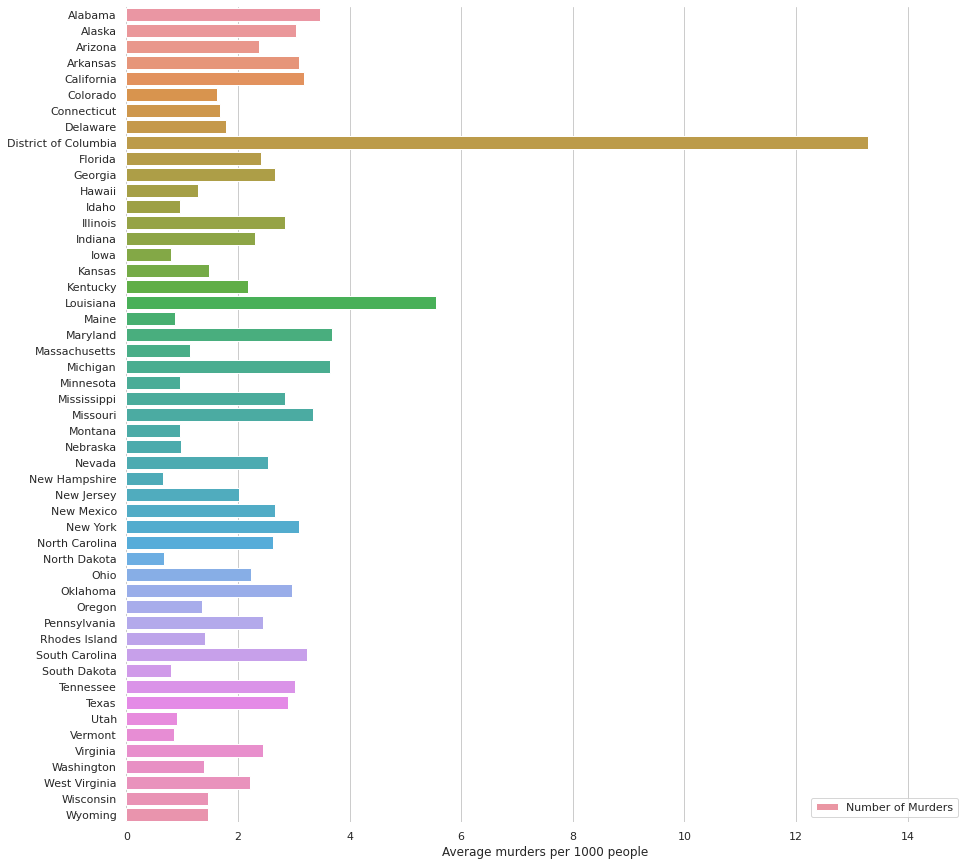

In [53]:
sns.set(style="whitegrid")

f, ax = plt.subplots(figsize=(15, 15))

sns.barplot(x="avg", y="NAME", data=avg_df, label="Number of Murders")

ax.legend(ncol=2, loc="lower right", frameon=True)
ax.set(xlim=(0, 15), ylabel="", xlabel="Average murders per 1000 people")
sns.despine(left=True, bottom=True)

In [54]:
total_state_max = avg_df['avg'].max()
state_max = avg_df[avg_df['avg'] == total_state_max]['NAME'].values[0]
total_state_min = avg_df['avg'].min()
state_max = avg_df[avg_df['avg'] == total_state_max]['NAME'].values[0]

print(state_max)
print('The state with the highest number of murders was', state_max,'with a total of', total_state_max, 'murders')
print('The state with the lowest number of murders was', state_min,'with a total of', total_state_min, 'murders')
print('The top 3 most dangerous states in terms of murders are:\n', avg_df.nlargest(3,'avg').to_string(index=False))

District of Columbia
The state with the highest number of murders was District of Columbia with a total of 13.283616872523888 murders
The state with the lowest number of murders was North Dakota with a total of 0.6538582112947288 murders
The top 3 most dangerous states in terms of murders are:
        avg                  NAME
 13.283617  District of Columbia
  5.550379             Louisiana
  3.683815              Maryland


**Insights:** We see that the first graph was indeed an example of framing bias and the actual states having the highest number of homicides are Columbia, Louisiana and Maryland.

### 3.9\. GeoMapping

Let us visualise this information on the map of America.

#### 3.9.1\. Homicides per state for unnormalized data
Plotting the number of homicides per state for the original unnormalized data. 

Text(0.5, 1.0, 'Geographic Homicide Distribution: Not Normalized Data')

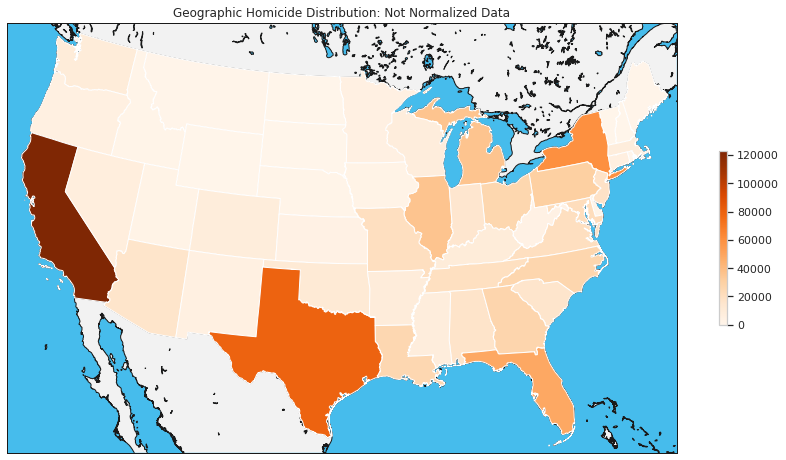

In [55]:

state = pd.DataFrame(data, columns = ['State']) 
count_states = state.stack().value_counts()
states = count_states.sort_index(axis=0, ascending=False)
states_eeuu = pd.DataFrame({'homicides':states, 'state':states.index})
states_name = states_eeuu.index
fig, ax = plt.subplots(figsize=(15,8))

m = Basemap(resolution='h', # c, l, i, h, f or None
            projection='lcc',
            lat_1=33,lat_2=45,lon_0=-95,
            llcrnrlon=-119,llcrnrlat=22,urcrnrlon=-64,urcrnrlat=49)

#Set shapefile to print states
#We get it from the basemap github page https://github.com/matplotlib/basemap/blob/master/examples/st99_d00.shp
m.readshapefile(root_path+'input/st99_d00', 'states')

#Set colors of map
m.drawmapboundary(fill_color='#46bcec')
m.fillcontinents(color='#f2f2f2',lake_color='#46bcec')
m.drawcoastlines()


#Merge info of shapes with homicides stats
geo = pd.DataFrame({
        'shapes': [Polygon(np.array(shape), True) for shape in m.states],
        'state': [state['NAME'] for state in m.states_info]
    })
geo = geo.merge(states_eeuu, on='state', how='left')

#Colour the map
cmap = plt.get_cmap('Oranges')   
pc = PatchCollection(geo.shapes, zorder=2)
norm = Normalize()
 
pc.set_facecolor(cmap(norm(geo['homicides'].fillna(0).values)))
ax.add_collection(pc)

#Add bar
mapper = matplotlib.cm.ScalarMappable(norm=norm, cmap=cmap)

mapper.set_array(geo['homicides'])
plt.colorbar(mapper, shrink=0.4)
plt.title("Geographic Homicide Distribution: Not Normalized Data")

**Insights:** From the map above it looks like California and texas are unsafe places.

#### 3.9.2\. Homicides per state for normalized data
Plotting the number of homicides per state for the normalized data we get the following graph


Text(0.5, 1.0, 'Geographic Homicide Distribution: Normalised Data')

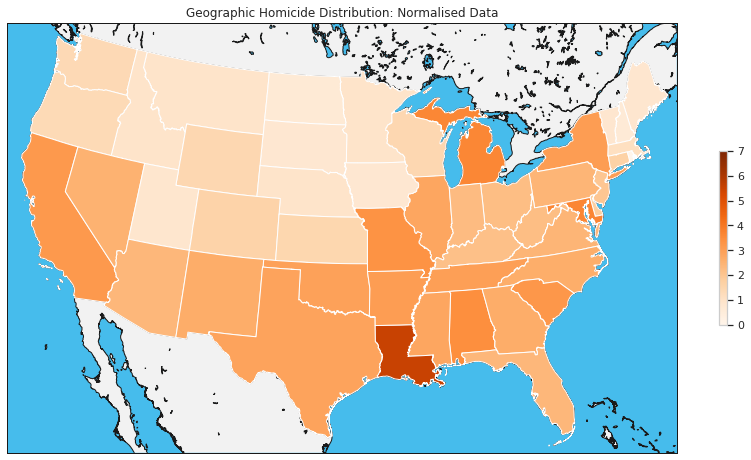

In [56]:
state = pd.DataFrame(data, columns = ['State']) 

count_states = state.stack().value_counts()
abcd = avg_df.set_index('NAME')['avg']
states = abcd.sort_index(axis=0, ascending=False)
states_eeuu = pd.DataFrame({'homicides':states, 'state':states.index})
states_name = states_eeuu.index
fig, ax = plt.subplots(figsize=(15,8))

m = Basemap(resolution='h', # c, l, i, h, f or None
            projection='lcc',
            lat_1=33,lat_2=45,lon_0=-95,
            llcrnrlon=-119,llcrnrlat=22,urcrnrlon=-64,urcrnrlat=49)

#Set shapefile to print states. 
#We get it from the basemap github page https://github.com/matplotlib/basemap/blob/master/examples/st99_d00.shp
m.readshapefile(root_path+'input/st99_d00', 'states')

#Set colors of map
m.drawmapboundary(fill_color='#46bcec')
m.fillcontinents(color='#f2f2f2',lake_color='#46bcec')
m.drawcoastlines()


#Merge info of shapes with homicides stats
geo = pd.DataFrame({
        'shapes': [Polygon(np.array(shape), True) for shape in m.states],
        'state': [state['NAME'] for state in m.states_info]
    })
geo = geo.merge(states_eeuu, on='state', how='left')

#Colour the map
cmap = plt.get_cmap('Oranges')   
pc = PatchCollection(geo.shapes, zorder=2)
norm = Normalize(vmin=0, vmax=7)
 
pc.set_facecolor(cmap(norm(geo['homicides'].fillna(0).values)))
ax.add_collection(pc)

#Add bar
mapper = matplotlib.cm.ScalarMappable(norm=norm, cmap=cmap)

mapper.set_array(geo['homicides'])
plt.colorbar(mapper, shrink=0.4)
plt.title("Geographic Homicide Distribution: Normalised Data")

**Insights:** The states that appear to have the maximum number of homicides are different.

#### 3.9.3\. Resolution Rate per state
Plotting the number of homicides per state.

Text(0.5, 1.0, 'Resolution rate (in %) of homicides by state')

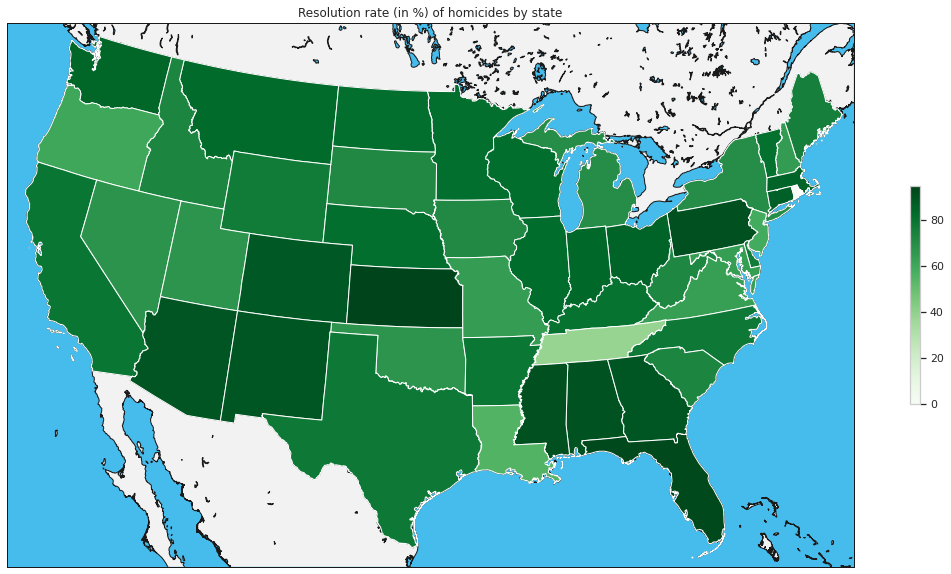

In [57]:
df = pd.DataFrame(data, columns = ['State','Solved']) 

homicides_state = df['State'].value_counts()

#Get solved 
mask = (df['Solved'] == 'Yes')
homicides_solved = pd.DataFrame(data.loc[mask], columns = ['State', 'Solved']) 
homicides_solved = homicides_solved['State'].value_counts()

#Get unsolved 
mask2 = (df['Solved'] == 'No')
homicides_unsolved = pd.DataFrame(data.loc[mask2], columns = ['State', 'Solved'])
homicides_unsolved = homicides_unsolved['State'].value_counts()
homicides = pd.DataFrame({'Solved':homicides_solved, 'Unsolved':homicides_unsolved})
homicides['Resolution Rate'] = (homicides['Solved'] *100 ) / (homicides['Solved'] + homicides['Unsolved'])

resolution_rate = pd.DataFrame({'state':states.index, 'resolution rate':homicides['Resolution Rate']})

#Set the resolution of the plot 
fig, ax = plt.subplots(figsize=(20,10))

#set type of map (projection) and lat&lon parameters
m = Basemap(resolution='h', # c, l, i, h, f or None
            projection='lcc',
            lat_1=33,lat_2=45,lon_0=-95,
            llcrnrlon=-119,llcrnrlat=22,urcrnrlon=-64,urcrnrlat=49)

#Set shapefile to print states
m.readshapefile(root_path+'input/st99_d00', 'states')

#Set colors of map
m.drawmapboundary(fill_color='#46bcec')
m.fillcontinents(color='#f2f2f2',lake_color='#46bcec')
m.drawcoastlines()


#Merge info of shapes with homicides stats
geo = pd.DataFrame({
        'shapes': [Polygon(np.array(shape), True) for shape in m.states],
        'state': [state['NAME'] for state in m.states_info]
    })
geo = geo.merge(resolution_rate, on='state', how='left')

#Colour the map
cmap = plt.get_cmap('Greens')   
pc = PatchCollection(geo.shapes, zorder=2)
norm = Normalize()
 
pc.set_facecolor(cmap(norm(geo['resolution rate'].fillna(0).values)))
ax.add_collection(pc)

#Add bar
mapper = matplotlib.cm.ScalarMappable(norm=norm, cmap=cmap)

mapper.set_array(geo['resolution rate'])
plt.colorbar(mapper, shrink=0.4)
plt.title("Resolution rate (in %) of homicides by state")

**Insights:** We see many places that are a darker shade of green (having a higher resolution rate). We were expecting this data since the number of resolved cases (70%) is more than the unresolved cases (30%). 

In [58]:
print('The top 5 states with best resolution rate are:\n', homicides.nlargest(5,'Resolution Rate').to_string(index=True))

The top 5 states with best resolution rate are:
               Solved  Unsolved  Resolution Rate
North Dakota     467        27        94.534413
South Dakota     637        48        92.992701
Montana          903        88        91.120081
Idaho           1458       146        90.897756
Wyoming          760        84        90.047393


In [59]:
print('The top 5 states with worst resolution rate are:\n', homicides.nsmallest(5,'Resolution Rate').to_string(index=True))

The top 5 states with worst resolution rate are:
                       Solved  Unsolved  Resolution Rate
District of Columbia    3396      5496        38.191633
New York               33223     27113        55.063312
Maryland               12972      8990        59.065659
Illinois               22012     14358        60.522409
California             77963     44878        63.466595


### 3.10\. Race and Sex Data Analysis

Since we will be looking for bias in the Race and Sex columns, let us visualize the properties of the data from the point of view of Race and Sex of offenders and the victims.

Text(0.5, 25.96, 'Race and Sex')

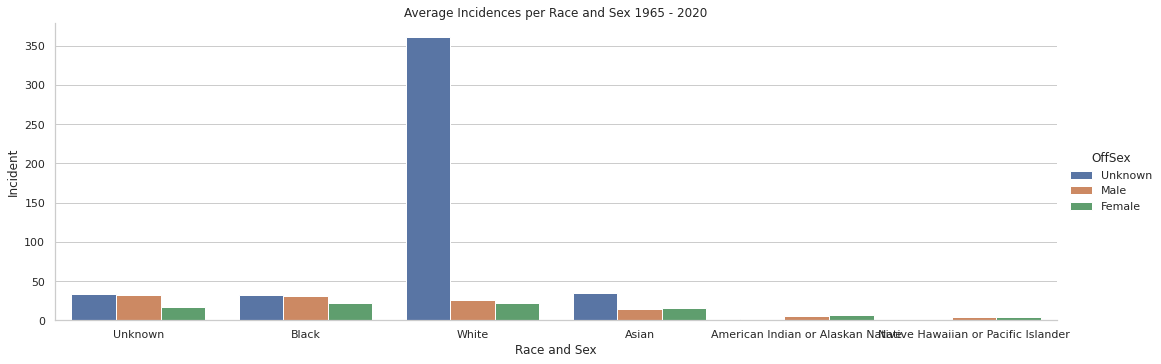

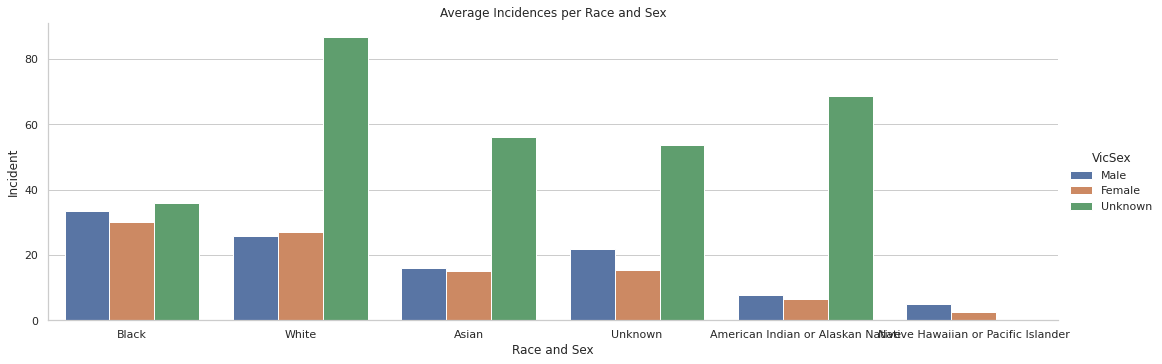

In [60]:
sns.catplot(x='OffRace',y='Incident',hue='OffSex',data=data, kind='bar',aspect=3,ci=None,palette= sns.color_palette())
plt.title('Average Incidences per Race and Sex 1965 - 2020')
plt.xlabel('Race and Sex')
sns.catplot(x='VicRace',y='Incident',hue='VicSex',data=data, kind='bar',aspect=3,ci=None,palette= sns.color_palette())
plt.title('Average Incidences per Race and Sex')
plt.xlabel('Race and Sex')

**Insights:** Caucasians have the most unknown values. The race distribution might have because of the race and age of the unsolved crimes are not known. From all the races, Asian/Pacific Islanders are the only ones who have more female than male offenders.

In [61]:
def plot_histo(data, col, Y_columns):
    df = data.copy()
    fig, axs = plt.subplots(1,2,figsize=(20,6))
    
    for i in range(0,2):
        cnt = []; y_col = Y_columns[i]
        Y_values = df[y_col].dropna().drop_duplicates().values
        for val in Y_values:
            cnt += [df[df[y_col] == val][col].values]
        bins = df[col].nunique()

        axs[i].hist(cnt, bins=bins, stacked=True)
        axs[i].legend(Y_values,loc='upper right')
        axs[i].set_title("Histogram of the "+col+" column by "+y_col)

    plt.show()

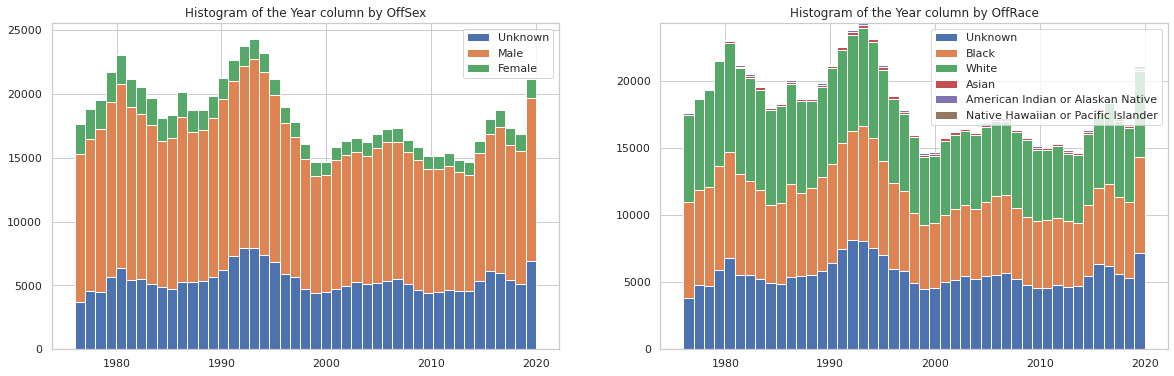

In [62]:
Y_columns = ['OffSex', 'OffRace', 'OffAge']
ignore_columns = ['Solved']
cat_columns = []
num_columns = []

for col in data.columns.values:
    if col in Y_columns+ignore_columns:
        continue
    elif data[col].dtypes == 'int64':
        num_columns += [col]
    else:
        cat_columns += [col]

plot_histo(data, col='Year',Y_columns=Y_columns)

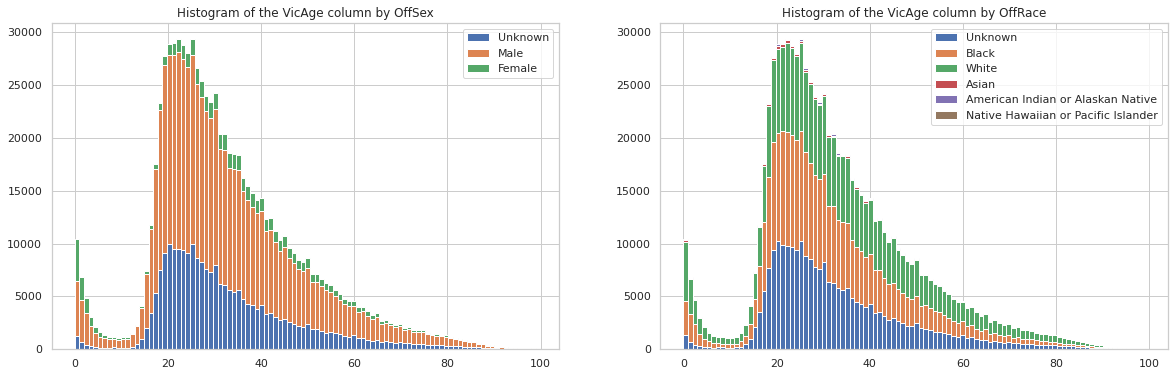

In [63]:
plot_histo(data, col='VicAge',Y_columns=Y_columns)

In [64]:
def plot_bar(data, col, Y_columns, max_cat=10, pos = "upper right"):
    df = data.copy()
    
    fig, axs = plt.subplots(1,2,figsize=(28,8))
    cat_val = df[col].value_counts()[0:max_cat].index.values
    df = df[df[col].isin(cat_val)]

    for i in range(0,2):
        y_col = Y_columns[i]
        Y_values = df[y_col].dropna().drop_duplicates().values
        labels = []
        for val in Y_values:
            cnt = df[df[y_col] == val][col].value_counts().sort_index()
            axs[i].bar(cnt.index.values, cnt.values)
            if not len(labels):
              labels = cnt.index.values
        axs[i].set_xticklabels(labels, rotation = 90)
        axs[i].legend(Y_values,loc=pos)
        axs[i].set_title("Bar plot of the "+col+" column by "+y_col)        
    plt.show()

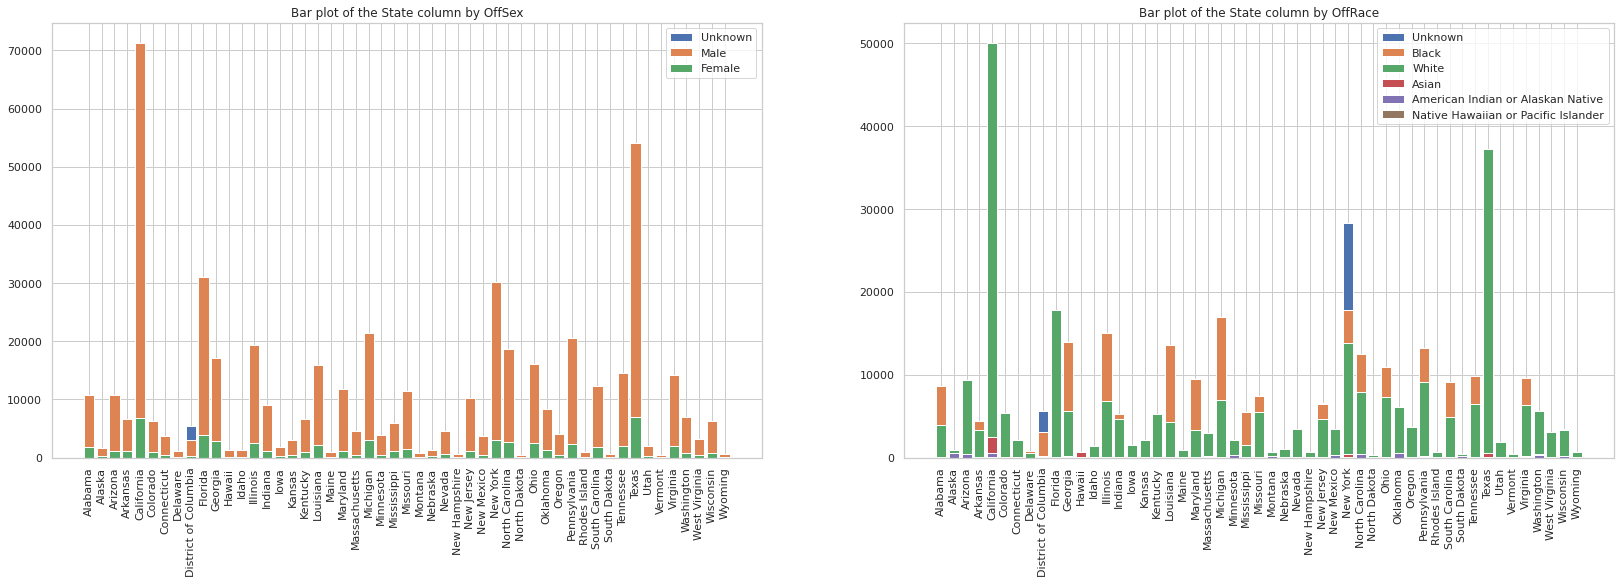

In [65]:
plot_bar(data, col='State',Y_columns=Y_columns, max_cat=51)

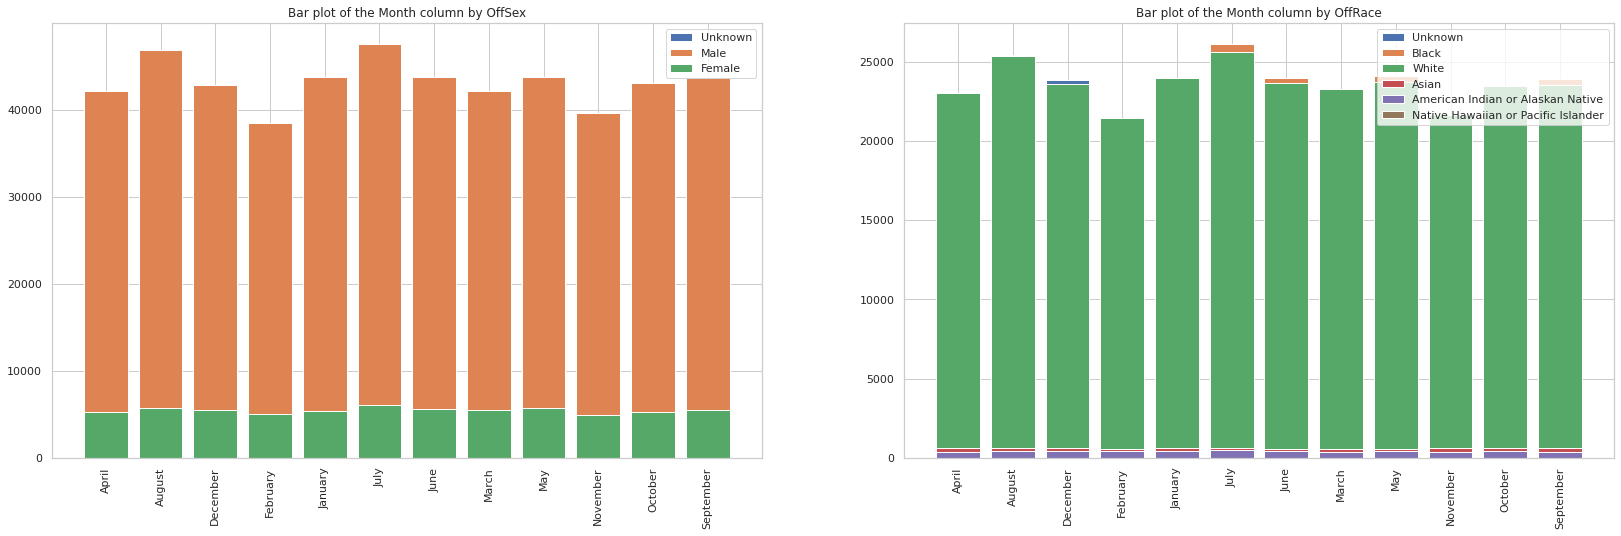

In [66]:
plot_bar(data, col='Month',Y_columns=Y_columns, max_cat=12)

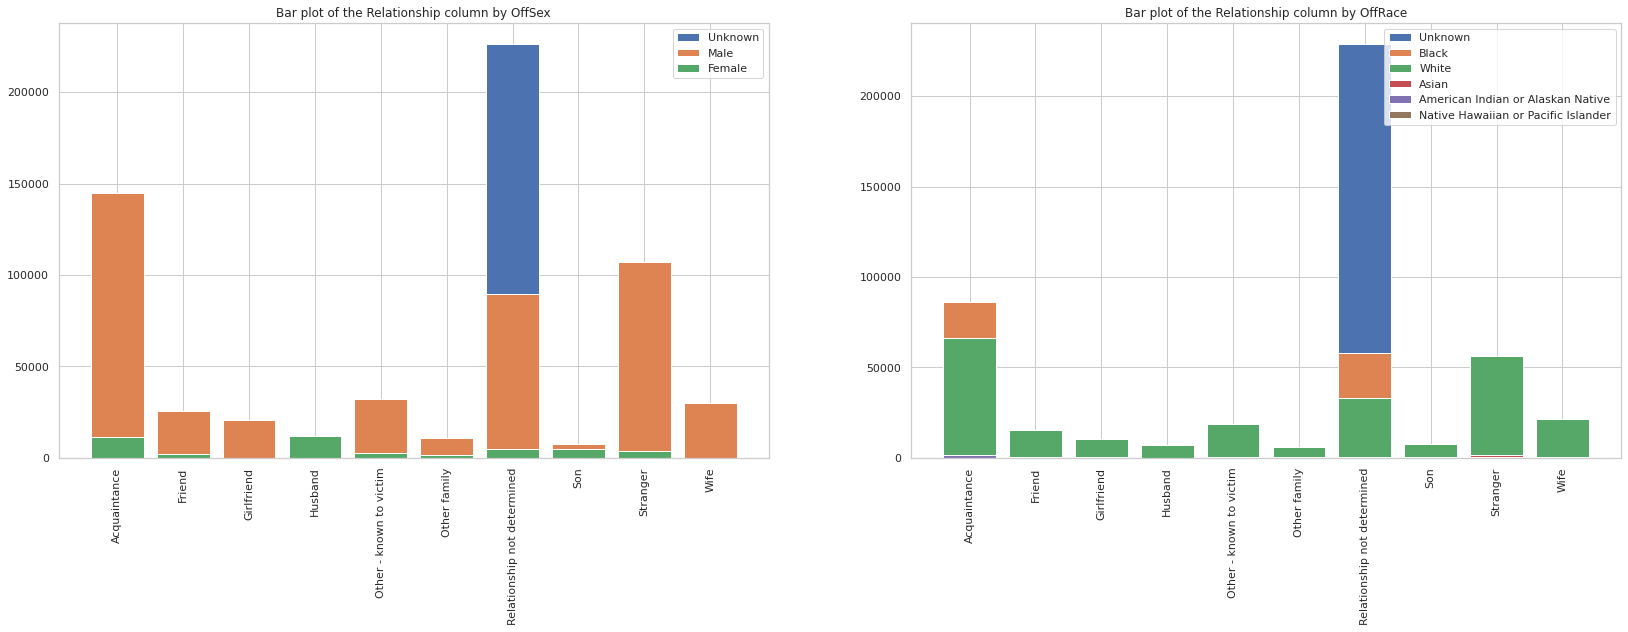

In [67]:
plot_bar(data, col='Relationship',Y_columns=Y_columns)

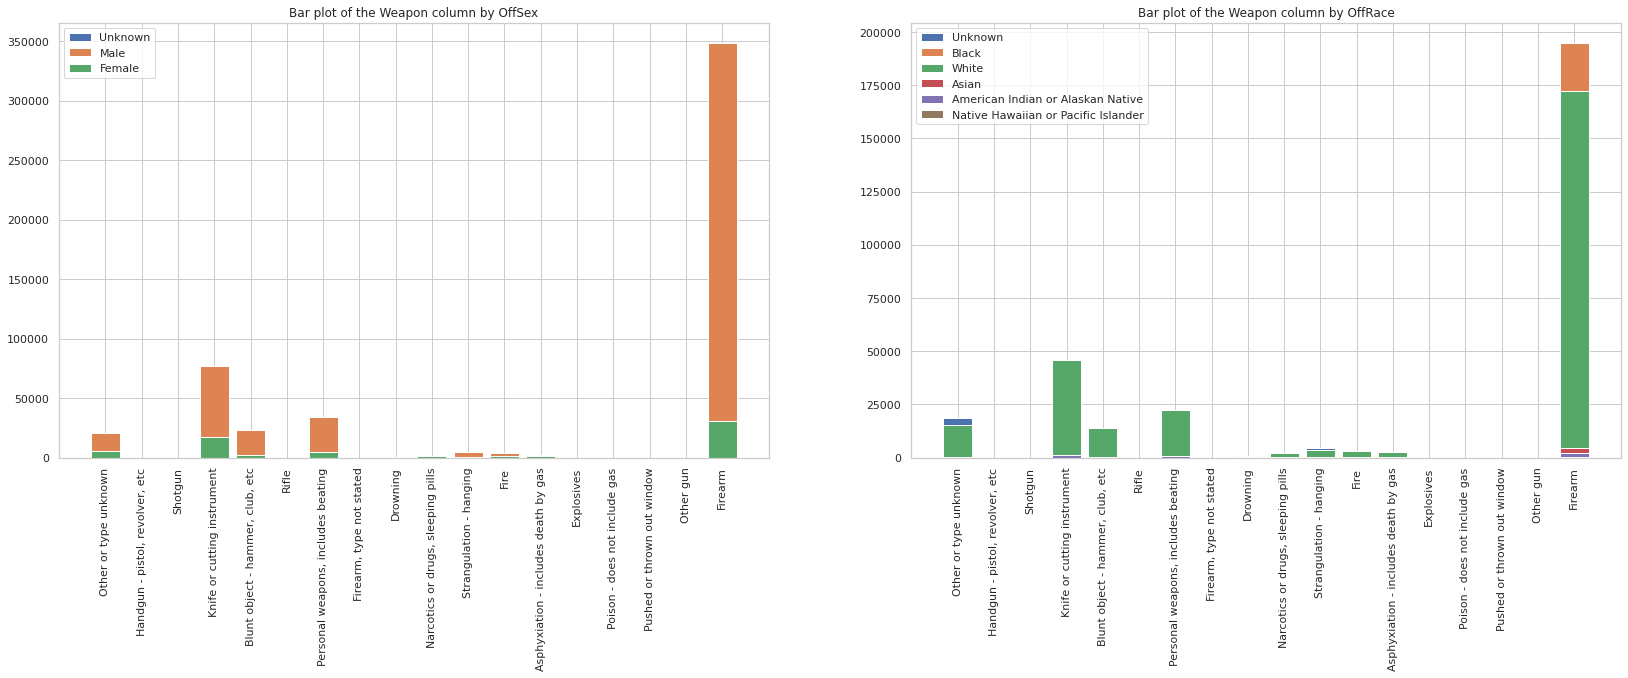

In [68]:
plot_bar(data, col='Weapon',Y_columns=Y_columns, pos = "upper left")

### 3.11\. Unsolved Cases Analysis


Check the relation between unsolved cases and a few other parameters.


#### 3.11.1\. Relationship of Perpetrator 


Undetermined Relationships = 226389



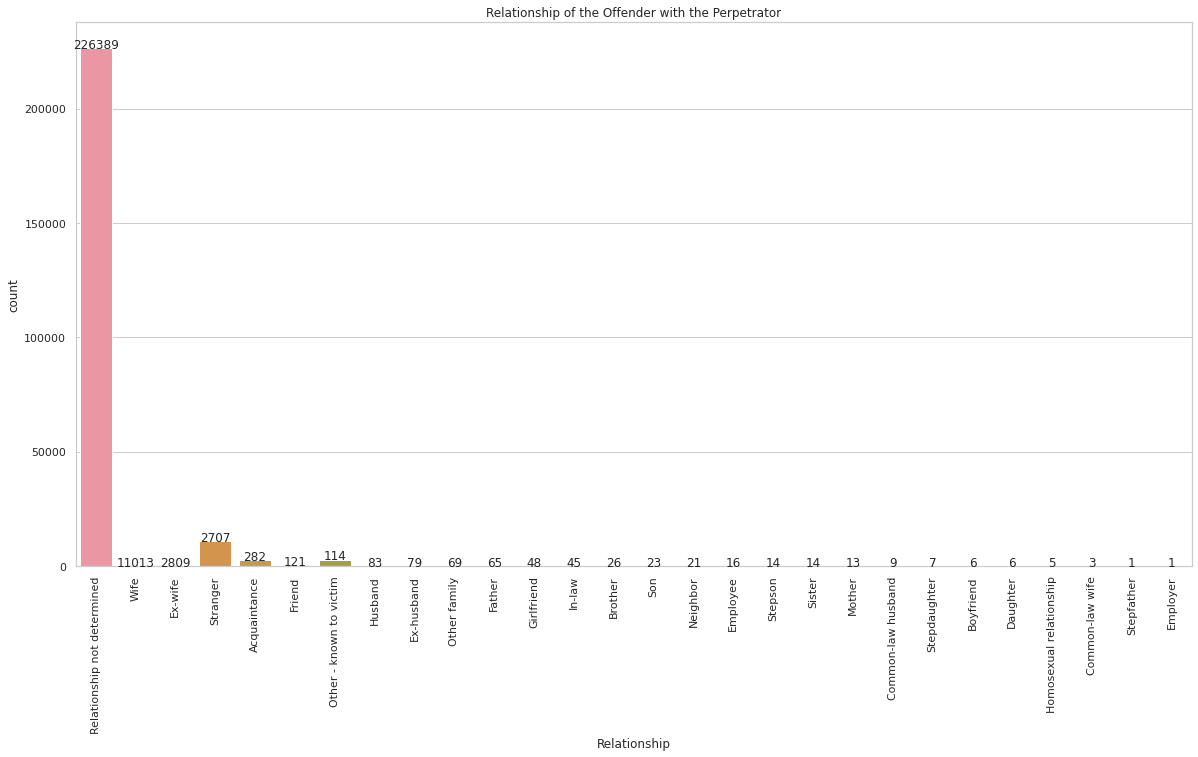

In [69]:
# data[(data["Solved"]=="No") & (data["Relationship"]=='Relationship not determined')]['Incident'].count()
unsolved_relationships = unsolved_df["Relationship"].value_counts(dropna = False)
fig2, ax2 = plt.subplots(figsize=(20,10))
plot2 = sns.countplot(ax = ax2, x="Relationship", data=unsolved_df)
plot2.set_xticklabels(plot2.get_xticklabels(), rotation = 90)
plot2.set_title(label='Relationship of the Offender with the Perpetrator')
showCounts(plot2, unsolved_relationships)
undetermined_rcount = unsolved_relationships["Relationship not determined"].sum()
print(f"Undetermined Relationships = {undetermined_rcount}\n")

**Insights:** Most of our data doesn't have the exact data on the relationship with the victim which is expected as these are unsolved cases and most of the times, we do not have much information on the perpetrator attributes.

#### 3.11.1\. Ethnicity of Victim and Perpetrator 


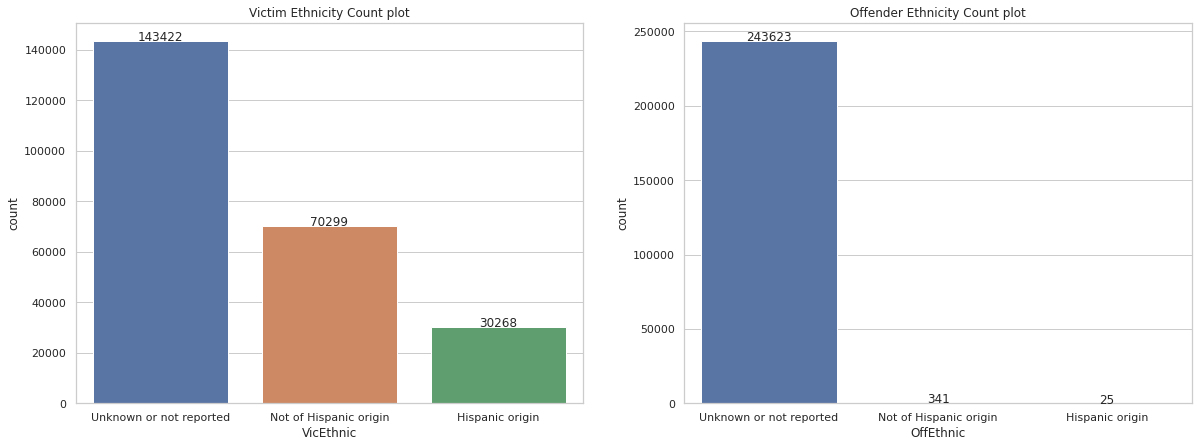

In [70]:
# data[(data["Solved"]=="No") & (data["VicEthnic"]=='Unknown or not reported')]['Incident'].count()
# data[(data["Solved"]=="No") & (data["OffEthnic"]=='Unknown or not reported')]['Incident'].count()
unsolved_victimm_ethnic = unsolved_df["VicEthnic"].value_counts(dropna = False)
unsolved_offender_ethnic = unsolved_df["OffEthnic"].value_counts(dropna = False)
fig3, ax3 = plt.subplots(figsize=(20,7), nrows=1, ncols=2)
plot3 = sns.countplot(ax = ax3[0], x="VicEthnic", data=unsolved_df)
plot4 = sns.countplot(ax = ax3[1], x="OffEthnic", data=unsolved_df)
plot3.set_title(label='Victim Ethnicity Count plot')
plot4.set_title(label='Offender Ethnicity Count plot')
showCounts(plot3, unsolved_victimm_ethnic)
showCounts(plot4, unsolved_offender_ethnic)

**Insights:** 
1. Based on all the unsolved homicide data, we see that we have information on only 20% of the Victims and other victims are either classified as Non-Hispanic or Unknown.
2. Also, our data (as expected) doesn't have the data on the ethnicity of the offender which is expected as these are unsolved cases

#### 3.11.1\. Offender Count

Unknown Offender Counts = 236722



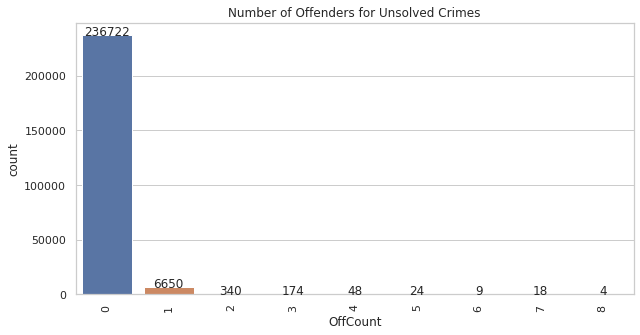

In [71]:
# data[(data["Solved"]=="No") & (data["OffCount"]==0)]['Incident'].count()
unsolved_offcount = unsolved_df["OffCount"].value_counts(dropna = False)
fig5, ax5 = plt.subplots(figsize=(10,5))
plot5 = sns.countplot(ax = ax5, x="OffCount", data=unsolved_df)
plot5.set_xticklabels(plot5.get_xticklabels(), rotation = 90)
plot5.set_title(label='Number of Offenders for Unsolved Crimes') # Confirm with Saumya on what is offcount?
showCounts(plot5, unsolved_offcount)
unknown_offcount = unsolved_offcount[0].sum()
print(f"Unknown Offender Counts = {unknown_offcount}\n")

**Insights:** Even though we have the data of count of ~7000 offenders, most of the data doesn't have any information on how many people were involved in the incident.

### 3.12\. Annual income

Let us check if there is a correlation between the average income in a particular state and the number of murders in the state. 

#### 3.12.1\. Census Data Acquisition

We get the income information from the US census data [here](https://www.census.gov/data/tables/time-series/demo/income-poverty/historical-income-households.html). 

In [72]:
income_states = pd.read_csv(root_path + "input/income_states.csv")
income_states.head(10)

,State,2020,2019,2018,2017,2016,2015,2014,2013,2012,2011,2010,2009,2008,2007,2006,2005,2004,2003,2002,2001,2000,1999,1998,1997,1996,1995,1994,1993,1992,1991,1990,1989,1988,1987,1986,1985,1984
0,United States,"67,521","68,703","63,179","61,372","59,039","56,516","53,657","53,585","51,017","50,054","49,276","49,777","50,303","50,233","48,201","46,326","44,334","43,318","42,409","42,228","41,990","40,696","38,885","37,005","35,492","34,076","32,264","31,241","30,636","30,126","29,943","28,906","27,225","26,061","24,897","23,618","22,415"
1,Alabama,"54,393","56,200","49,936","51,113","47,221","44,509","42,278","47,320","43,464","42,590","40,933","39,980","44,476","42,212","37,952","37,150","36,629","37,255","37,603","35,160","35,424","36,251","36,266","31,939","30,302","25,991","27,196","25,082","25,808","24,346","23,357","21,284","19,948","19,734","19,132","18,333","17,310"
2,Alaska,"74,476","78,394","68,734","72,231","75,723","75,112","67,629","72,472","63,648","57,431","57,848","61,604","63,989","62,993","56,418","55,891","55,063","51,837","52,774","57,363","52,847","51,396","50,692","47,994","52,779","47,954","45,367","42,931","41,802","40,612","39,298","36,006","33,103","33,233","31,356","34,782","32,356"
3,Arizona,"66,628","70,674","62,283","61,125","57,100","52,248","49,254","52,611","47,044","48,621","46,896","45,739","46,914","47,215","46,657","45,245","43,846","41,166","39,734","42,704","39,783","36,995","37,090","32,740","31,637","30,863","31,293","30,510","29,358","30,737","29,224","28,552","26,435","26,749","25,500","23,877","21,425"
4,Arkansas,"50,540","54,539","49,781","48,829","45,907","42,798","44,922","39,376","39,018","41,302","38,587","36,538","39,586","40,795","37,057","36,658","34,984","32,002","32,387","33,339","29,697","29,682","27,665","26,162","27,123","25,814","25,565","23,039","23,882","23,435","22,786","21,433","20,172","18,827","18,730","17,451","15,674"
5,California,"77,358","78,105","70,489","69,759","66,637","63,636","60,487","60,794","57,020","53,367","54,283","56,134","57,014","55,734","55,319","51,755","49,222","49,300","47,437","47,262","46,816","43,629","40,934","39,694","38,812","37,009","35,331","34,073","34,903","33,664","33,290","33,009","30,287","30,146","29,010","26,981","25,287"
6,Colorado,"82,611","72,499","73,034","74,172","70,566","66,596","60,940","67,912","57,255","58,629","60,233","55,930","60,943","61,141","55,697","50,449","50,886","49,940","48,294","49,397","48,240","48,177","46,599","43,233","40,950","40,706","37,833","34,488","32,484","31,499","30,733","26,806","26,214","26,476","27,192","28,182","25,801"
7,Connecticut,"79,043","87,291","72,812","72,780","75,923","72,889","70,161","69,291","64,247","65,415","65,998","64,851","64,682","64,141","62,404","56,835","55,100","54,965","53,387","53,347","50,172","50,593","46,508","43,985","42,119","40,243","41,097","39,516","40,841","42,154","38,870","42,321","36,213","32,862","32,721","31,090","29,951"
8,Delaware,"69,132","74,194","65,012","62,318","58,046","57,756","57,522","54,091","48,972","54,660","55,214","52,114","50,702","54,589","52,438","51,235","48,049","49,019","49,650","49,602","50,365","46,628","41,458","43,033","39,309","34,928","35,873","36,064","35,678","32,585","30,804","32,068","30,505","29,244","25,626","22,980","25,819"
9,District of Columbia,"88,311","93,111","85,750","83,382","70,982","70,071","68,277","60,057","65,246","55,251","56,928","53,141","55,590","50,783","48,477","44,993","43,451","45,044","39,070","41,169","41,222","38,670","33,433","31,860","31,966","30,748","30,116","27,304","30,247","29,885","27,392","26,752","26,741","27,455","24,322","21,076","20,408"


In [73]:
income_states["State"].values

array(['United States', 'Alabama', 'Alaska', 'Arizona', 'Arkansas',
       'California', 'Colorado', 'Connecticut', 'Delaware',
       'District of Columbia', 'Florida', 'Georgia', 'Hawaii', 'Idaho',
       'Illinois', 'Indiana', 'Iowa', 'Kansas', 'Kentucky', 'Louisiana',
       'Maine', 'Maryland', 'Massachusetts', 'Michigan', 'Minnesota',
       'Mississippi', 'Missouri', 'Montana', 'Nebraska', 'Nevada',
       'New Hampshire', 'New Jersey', 'New Mexico', 'New York',
       'North Carolina', 'North Dakota', 'Ohio', 'Oklahoma', 'Oregon',
       'Pennsylvania', 'Rhode Island', 'South Carolina', 'South Dakota',
       'Tennessee', 'Texas', 'Utah', 'Vermont', 'Virginia', 'Washington',
       'West Virginia', 'Wisconsin', 'Wyoming'], dtype=object)

In [74]:
len(income_states["State"].values)

52

#### 3.12.2\. Data Cleaning and Integration

We take the average annual income from 1984 to 2020. We also do some data cleaning, convert the incom columns to numeric data.

In [75]:
income_states = income_states.replace(',','', regex=True)

In [76]:
income_states.head(10)

,State,2020,2019,2018,2017,2016,2015,2014,2013,2012,2011,2010,2009,2008,2007,2006,2005,2004,2003,2002,2001,2000,1999,1998,1997,1996,1995,1994,1993,1992,1991,1990,1989,1988,1987,1986,1985,1984
0,United States,67521,68703,63179,61372,59039,56516,53657,53585,51017,50054,49276,49777,50303,50233,48201,46326,44334,43318,42409,42228,41990,40696,38885,37005,35492,34076,32264,31241,30636,30126,29943,28906,27225,26061,24897,23618,22415
1,Alabama,54393,56200,49936,51113,47221,44509,42278,47320,43464,42590,40933,39980,44476,42212,37952,37150,36629,37255,37603,35160,35424,36251,36266,31939,30302,25991,27196,25082,25808,24346,23357,21284,19948,19734,19132,18333,17310
2,Alaska,74476,78394,68734,72231,75723,75112,67629,72472,63648,57431,57848,61604,63989,62993,56418,55891,55063,51837,52774,57363,52847,51396,50692,47994,52779,47954,45367,42931,41802,40612,39298,36006,33103,33233,31356,34782,32356
3,Arizona,66628,70674,62283,61125,57100,52248,49254,52611,47044,48621,46896,45739,46914,47215,46657,45245,43846,41166,39734,42704,39783,36995,37090,32740,31637,30863,31293,30510,29358,30737,29224,28552,26435,26749,25500,23877,21425
4,Arkansas,50540,54539,49781,48829,45907,42798,44922,39376,39018,41302,38587,36538,39586,40795,37057,36658,34984,32002,32387,33339,29697,29682,27665,26162,27123,25814,25565,23039,23882,23435,22786,21433,20172,18827,18730,17451,15674
5,California,77358,78105,70489,69759,66637,63636,60487,60794,57020,53367,54283,56134,57014,55734,55319,51755,49222,49300,47437,47262,46816,43629,40934,39694,38812,37009,35331,34073,34903,33664,33290,33009,30287,30146,29010,26981,25287
6,Colorado,82611,72499,73034,74172,70566,66596,60940,67912,57255,58629,60233,55930,60943,61141,55697,50449,50886,49940,48294,49397,48240,48177,46599,43233,40950,40706,37833,34488,32484,31499,30733,26806,26214,26476,27192,28182,25801
7,Connecticut,79043,87291,72812,72780,75923,72889,70161,69291,64247,65415,65998,64851,64682,64141,62404,56835,55100,54965,53387,53347,50172,50593,46508,43985,42119,40243,41097,39516,40841,42154,38870,42321,36213,32862,32721,31090,29951
8,Delaware,69132,74194,65012,62318,58046,57756,57522,54091,48972,54660,55214,52114,50702,54589,52438,51235,48049,49019,49650,49602,50365,46628,41458,43033,39309,34928,35873,36064,35678,32585,30804,32068,30505,29244,25626,22980,25819
9,District of Columbia,88311,93111,85750,83382,70982,70071,68277,60057,65246,55251,56928,53141,55590,50783,48477,44993,43451,45044,39070,41169,41222,38670,33433,31860,31966,30748,30116,27304,30247,29885,27392,26752,26741,27455,24322,21076,20408


In [77]:
cols = income_states.columns.drop('State')
income_states[cols] = income_states[cols].apply(pd.to_numeric, errors='coerce')

In [78]:
all_years = [str(year) for year in range(1984,2021)]
income_states['avg_income'] = income_states[all_years].mean(axis = 1).astype(int)

In [79]:
income_states.State.values

array(['United States', 'Alabama', 'Alaska', 'Arizona', 'Arkansas',
       'California', 'Colorado', 'Connecticut', 'Delaware',
       'District of Columbia', 'Florida', 'Georgia', 'Hawaii', 'Idaho',
       'Illinois', 'Indiana', 'Iowa', 'Kansas', 'Kentucky', 'Louisiana',
       'Maine', 'Maryland', 'Massachusetts', 'Michigan', 'Minnesota',
       'Mississippi', 'Missouri', 'Montana', 'Nebraska', 'Nevada',
       'New Hampshire', 'New Jersey', 'New Mexico', 'New York',
       'North Carolina', 'North Dakota', 'Ohio', 'Oklahoma', 'Oregon',
       'Pennsylvania', 'Rhode Island', 'South Carolina', 'South Dakota',
       'Tennessee', 'Texas', 'Utah', 'Vermont', 'Virginia', 'Washington',
       'West Virginia', 'Wisconsin', 'Wyoming'], dtype=object)

Before joining the data let us check if the states match.

In [80]:
set(income_states.State.values)- set(data.State.unique())

{'Rhode Island', 'United States'}

Looks like there is a discriancy in 'Rhode Island' and 'Rhodes Island'. Let us fix that. 

In [81]:
for index in income_states.index:
    if income_states.loc[index,'State'] == 'Rhode Island':
        income_states.loc[index, 'State'] = 'Rhodes Island'
        break
income_states.State.unique()

array(['United States', 'Alabama', 'Alaska', 'Arizona', 'Arkansas',
       'California', 'Colorado', 'Connecticut', 'Delaware',
       'District of Columbia', 'Florida', 'Georgia', 'Hawaii', 'Idaho',
       'Illinois', 'Indiana', 'Iowa', 'Kansas', 'Kentucky', 'Louisiana',
       'Maine', 'Maryland', 'Massachusetts', 'Michigan', 'Minnesota',
       'Mississippi', 'Missouri', 'Montana', 'Nebraska', 'Nevada',
       'New Hampshire', 'New Jersey', 'New Mexico', 'New York',
       'North Carolina', 'North Dakota', 'Ohio', 'Oklahoma', 'Oregon',
       'Pennsylvania', 'Rhodes Island', 'South Carolina', 'South Dakota',
       'Tennessee', 'Texas', 'Utah', 'Vermont', 'Virginia', 'Washington',
       'West Virginia', 'Wisconsin', 'Wyoming'], dtype=object)

In [82]:
set(income_states.State.values)- set(data.State.unique())

{'United States'}

In [83]:
incidences = data.groupby('State')['Incident'].agg('count')
incidences.head(10)

State
Alabama                  16796
Alaska                    2233
Arizona                  16364
Arkansas                  9200
California              122841
Colorado                  8846
Connecticut               6025
Delaware                  1685
District of Columbia      8892
Florida                  48740
Name: Incident, dtype: int64

In [84]:
avg_df_inc = income_states.merge(incidences, left_on = "State", right_on = "State", how = 'inner')

In [85]:
avg_df_inc = avg_df_inc[['State','avg_income','Incident']]
avg_df_inc.head(5)

,State,avg_income,Incident
0,Alabama,35299,16796
1,Alaska,53949,2233
2,Arizona,41256,16364
3,Arkansas,32867,9200
4,California,47945,122841


#### 3.12.3\. Trends in Income distribution

Let us check if there is a trend between the average income in the state and the number of incidents.


<img src="http://media.giphy.com/media/Jjk98QzZwlTji/giphy.gif" width="300" />

Text(0.5, 1.0, 'Income vs number of incidents')

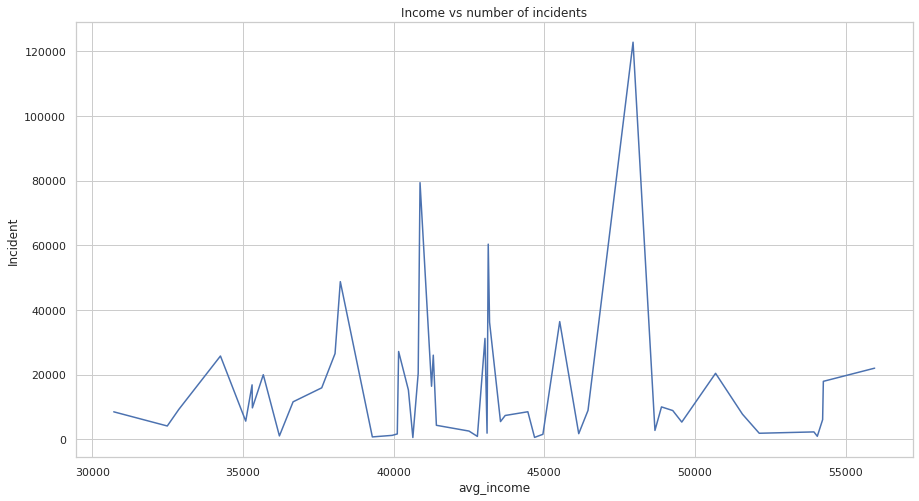

In [86]:
sns.lineplot(x='avg_income',y='Incident',data=avg_df_inc).set_title("Income vs number of incidents")

**Insights:** The is no particular increasing or decreasing trend but there is a spike between the 45000 and 50000 income. 

What if we plot a normalized value? Let us check if it will give us better results.

In [87]:
avg_df_avg_pop_inc = income_states.merge(avg_df, left_on = "State", right_on = "NAME", how = 'inner')
avg_df_avg_pop_inc.head(5)

,State,2020,2019,2018,2017,2016,2015,2014,2013,2012,2011,2010,2009,2008,2007,2006,2005,2004,2003,2002,2001,2000,1999,1998,1997,1996,1995,1994,1993,1992,1991,1990,1989,1988,1987,1986,1985,1984,avg_income,avg,NAME
0,Alabama,54393,56200,49936,51113,47221,44509,42278,47320,43464,42590,40933,39980,44476,42212,37952,37150,36629,37255,37603,35160,35424,36251,36266,31939,30302,25991,27196,25082,25808,24346,23357,21284,19948,19734,19132,18333,17310,35299,3.459989,Alabama
1,Alaska,74476,78394,68734,72231,75723,75112,67629,72472,63648,57431,57848,61604,63989,62993,56418,55891,55063,51837,52774,57363,52847,51396,50692,47994,52779,47954,45367,42931,41802,40612,39298,36006,33103,33233,31356,34782,32356,53949,3.045550,Alaska
2,Arizona,66628,70674,62283,61125,57100,52248,49254,52611,47044,48621,46896,45739,46914,47215,46657,45245,43846,41166,39734,42704,39783,36995,37090,32740,31637,30863,31293,30510,29358,30737,29224,28552,26435,26749,25500,23877,21425,41256,2.383913,Arizona
3,Arkansas,50540,54539,49781,48829,45907,42798,44922,39376,39018,41302,38587,36538,39586,40795,37057,36658,34984,32002,32387,33339,29697,29682,27665,26162,27123,25814,25565,23039,23882,23435,22786,21433,20172,18827,18730,17451,15674,32867,3.086854,Arkansas
4,California,77358,78105,70489,69759,66637,63636,60487,60794,57020,53367,54283,56134,57014,55734,55319,51755,49222,49300,47437,47262,46816,43629,40934,39694,38812,37009,35331,34073,34903,33664,33290,33009,30287,30146,29010,26981,25287,47945,3.176609,California


In [88]:
avg_df_avg_pop_inc = avg_df_avg_pop_inc[['NAME','avg_income','avg']]
avg_df_avg_pop_inc.head(5)

,NAME,avg_income,avg
0,Alabama,35299,3.459989
1,Alaska,53949,3.045550
2,Arizona,41256,2.383913
3,Arkansas,32867,3.086854
4,California,47945,3.176609


Text(0.5, 1.0, 'Avg Income vs Avg number of incidents')

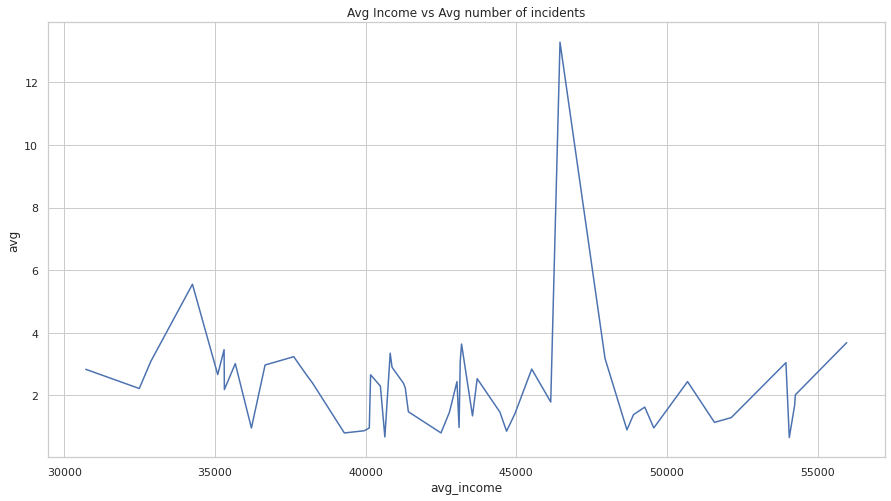

In [89]:
sns.lineplot(x='avg_income', y='avg', data=avg_df_avg_pop_inc).set_title("Avg Income vs Avg number of incidents")

**Insights:** The is no particular increasing or decreasing trend for the normalized value wither but there is a sharper spike between the 45000 and 50000 income which shows us that there is definitely a higher possibility of homicides occuring in states that have an income in that ranges.

In [90]:
avg_income_dict = {}
for index in avg_df_avg_pop_inc.index:
    avg_income_dict[avg_df_avg_pop_inc.loc[index, 'NAME']] = avg_df_avg_pop_inc.loc[index, 'avg_income']
avg_pop_dict = {}
for index in avg_df_avg_pop_inc.index:
    avg_pop_dict[avg_df_avg_pop_inc.loc[index, 'NAME']] = avg_df_avg_pop_inc.loc[index, 'avg']

In [91]:
data["AvgInc"] = data.apply(lambda row: avg_income_dict[row.State], axis=1)
data["AvgPop"] = data.apply(lambda row: avg_pop_dict[row.State], axis=1)
data.head(5)

,State,Source,Solved,Year,Month,Incident,ActionType,Homicide,Situation,VicAge,VicSex,VicRace,VicEthnic,OffAge,OffSex,OffRace,OffEthnic,Weapon,Relationship,Circumstance,VicCount,OffCount,AvgInc,AvgPop
0,Alabama,FBI,No,1976,September,1,Normal update,Murder and non-negligent manslaughter,Single victim/unknown offender(s),30.0,Male,Black,Unknown or not reported,NaN,Unknown,Unknown,Unknown or not reported,Other or type unknown,Relationship not determined,Other,0,0,35299,3.459989
1,Alabama,FBI,Yes,1977,January,1,Normal update,Murder and non-negligent manslaughter,Single victim/single offender,65.0,Female,Black,Unknown or not reported,62.0,Male,Black,Unknown or not reported,Other or type unknown,Acquaintance,Brawl due to influence of alcohol,0,0,35299,3.459989
2,Alabama,FBI,Yes,1977,March,1,Normal update,Murder and non-negligent manslaughter,Single victim/multiple offenders,48.0,Male,White,Unknown or not reported,52.0,Male,White,Unknown or not reported,Firearm,Acquaintance,Other arguments,0,1,35299,3.459989
3,Alabama,FBI,Yes,1977,March,1,Normal update,Murder and non-negligent manslaughter,Single victim/single offender,27.0,Male,Black,Unknown or not reported,22.0,Female,Black,Unknown or not reported,Firearm,Husband,Other arguments,0,0,35299,3.459989
4,Alabama,FBI,Yes,1977,August,1,Normal update,Murder and non-negligent manslaughter,Single victim/single offender,17.0,Female,Black,Unknown or not reported,21.0,Male,Black,Unknown or not reported,Knife or cutting instrument,Acquaintance,Circumstances undetermined,0,0,35299,3.459989


We save the data to a csv file to be used of modelling.

In [92]:
data.to_csv(root_path+"input/decoded_data_with_avg.csv", sep='\t', encoding='utf-8')

We got some really interesting insights from the data. We will now move on to the modeling and bias detection and mitigation in [this](https://colab.research.google.com/drive/1vxxnjs-sJ4nQHd0C8e5HcWF2vb1QuOVB?usp=sharing) notebook.